In [1]:
# Run first time when using this notebook to install all the dependencies.
# !pip install plotly pandas matplotlib clean-text unidecode openpyxl kaleido scipy

In [2]:
import pandas as pd
import math
import re
import random
from collections import defaultdict, OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from textwrap import wrap
from cleantext import clean
from IPython.display import display, Markdown, Latex
import plotly.express as px
import plotly.io as pio
import scipy.ndimage
import io 
from PIL import Image
import plotly.graph_objects as go
pio.renderers.default = "svg"

In [3]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
THEME_COLORS = ['#e43921', '#00c7d4', '#00ad46', '#017cee', '#54a7f3', '#4a4848', '#11e1ee', '#528cb7']

def extract_chart_data(opts, responses, sort_by_num_responses=True, as_dict=False):
    res_dict = OrderedDict({k: 0 for k in opts})
    res_dict["Not Answered"] = 0
    for res in responses:
        if not res or str(res) == "nan" or len(str(res)) == 0:
            res_dict["Not Answered"] += 1
            continue
        for opt in opts:
            res = str(res)
            opt = str(opt)
            if opt in res:
                res_dict[opt] += 1
                res = res.replace(opt, '')
    choices, responses = [], []
    for k, v in res_dict.items():
        choices.append('\n'.join(wrap(k, 50)))
        responses.append(v)
    df_dict = { 'choices': choices, 'responses': responses }
    
    if as_dict:
        return OrderedDict({
            choices[i]: responses[i]
            for i in range(len(choices))
        })
    
    df = pd.DataFrame.from_dict(df_dict)
    if sort_by_num_responses:
        not_answered_df = df[df['choices'] == 'Not Answered']
        df = df[df['choices'] != 'Not Answered'].sort_values(by=['responses'], ascending=False)
        df = pd.concat([df, not_answered_df], ignore_index=True, sort=False)
    return df

def _pct_func_pie(pct, allvals):
    absolute = int(round(pct/100.*np.sum(allvals)))
    return "{:d}\n({:.1f}%)\n".format(absolute, pct)

def plot_checkbox_question_pie(opts, responses):
    opts_mapping = None
    if isinstance(opts, dict):
        opts_mapping = {**opts}
        opts = list(opts.keys())
    df = extract_chart_data(opts, responses)
    data, choices = df['responses'], df['choices']
    if opts_mapping is not None:
        choices = [opts_mapping[i] for i in choices]
    fig, ax = plt.subplots(figsize=(10, 7), subplot_kw=dict(aspect="equal"))
    wedges, texts, autotexts = ax.pie(
        data, colors=THEME_COLORS, labels=choices, 
        autopct=lambda pct: _pct_func_pie(pct, data),
        textprops=dict(color="black"),
    )
    plt.setp(autotexts, size=8, weight="bold")
    plt.show()

def plot_checkbox_question_bar(opts, responses, title=None, sort_by_num_responses=True, xlabel="Number of Responses"):
    opts_mapping = None
    if isinstance(opts, dict):
        opts_mapping = {**opts}
        opts = list(opts.keys())
    df = extract_chart_data(opts, responses, sort_by_num_responses)
    data, choices = df['responses'], df['choices']
    if opts_mapping is not None:
        choices = [opts_mapping[i] for i in choices]
    fig, ax = plt.subplots()
    y_pos = np.arange(len(choices))
    error = np.random.rand(len(choices))
    bars = ax.barh(y_pos, data, xerr=error, align='center', color=THEME_COLORS)
    ax.set_yticks(y_pos, labels=choices, fontsize=7)
    ax.invert_yaxis()
    ax.set_xlabel(xlabel)
    ax.set_title(title or '')
    ax.bar_label(bars)
    plt.show()

def plot_checkbox_question_dotplot(opts, responses, title=None, sort_by_num_responses=True, xlabel="Number of Responses"):
    opts_mapping = None
    if isinstance(opts, dict):
        opts_mapping = {**opts}
        opts = list(opts.keys())
    df = extract_chart_data(opts, responses, sort_by_num_responses)
    if opts_mapping is not None:
        df['choices'] = df['choices'].apply(lambda row: opts_mapping[row])
    fig = px.scatter(df, x="choices", y="responses", color="responses",
        title=title or '', labels={"responses": xlabel, "choices": "Choices"}, text="responses",
    )
    total_responses = df['responses'].sum()
    marker_size = (df['responses'] * (100 / total_responses)) + 20
    fig.update_traces(marker=dict(size=marker_size, color=THEME_COLORS))
    fig.update_layout(
        font=dict(
            size=15,
            color="Black",
        )
    )
    fig.update_traces(textfont_size=10, textfont_color='white', textfont_weight='bold')
    fig.show()

def plot_multichoice_question(survey_df, base_question, opts, num_ranks=5, ranks=None, choices_as_x=False):
    ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(n//10%10!=1)*(n%10<4)*n%10::4])
    items = []
    not_answered = []

    def _update_items(choices_dict, items, not_answered):
        for choice, num_responses in choices_dict.items():
                if isinstance(opts, dict):
                    choice = opts[choice] if choice == 'Not Answered' \
                        else f"{choice}: {opts[choice]}" 
                choice = '<br>'.join(wrap(choice, 30))
                if choice == 'Not Answered':
                    not_answered.append([category, choice, num_responses])
                else:
                    items.append([category, choice, num_responses])
    
    labels_dict = {'category': 'Categories', 'choice': 'Choices', 'num_responses': 'Number of Responses'}
    if not ranks:
        for i in range(num_ranks):
            category = f"{ordinal(i+1)}"
            response = survey_df[f"{base_question} [{category}]"]
            choices_dict = extract_chart_data(opts, response, sort_by_num_responses=False, as_dict=True)
            _update_items(choices_dict, items, not_answered)
    else:
        for rank in ranks:
            category = rank
            response = survey_df[f"{base_question} [{category}]"]
            choices_dict = extract_chart_data(opts, response, sort_by_num_responses=False, as_dict=True)
            _update_items(choices_dict, items, not_answered)

    if not_answered:
        items += not_answered
    items_df = pd.DataFrame(items, columns=list(labels_dict.keys()))
    # Uncomment below code to enable choice-wise bar charts.
    # choices = items_df['choice'].unique().tolist()
    # for choice in choices:
    #     choice_df = items_df[items_df['choice'] == choice]
    #     title = '<br>'.join(wrap(choice.replace('<br>', ' '), 65))
    #     if len(title.strip().split()) == 1:
    #         title = f"Choice: {title}"
    #     _plotly_bar_chart(choice_df, labels_dict, f"<b>{title}</b>", is_single_bar=True)
    title = f"<b>Consolidated chart with all choices</b>"
    return _plotly_bar_chart(items_df, labels_dict, title)

def __plotly_fig2array(fig):
    # convert a Plotly fig to  a RGB-array
    fig_bytes = fig.to_image(format="png")
    buf = io.BytesIO(fig_bytes)
    img = Image.open(buf)
    return np.asarray(img)

def _plotly_bar_chart(items_df, labels_dict, title, is_single_bar=False):
    cols = list(labels_dict.keys())
    fig = px.bar(
        items_df,
        x=cols[0], 
        y=cols[2],
        color=cols[1],
        barmode='group',
        text_auto=True,
        title=title,
        labels=labels_dict,
        width=1250,
        height=1250,
    )
    fig.update_layout(
        autosize=False,
        font=dict(size=18, color="Black"),
        legend = dict(
            font = dict(size = 12, color = "black"),
        )
    )
    fig.update_traces(
        textfont_size=15,
        textposition="outside"
    )
    if is_single_bar:
        fig.update_traces(marker=dict(color=THEME_COLORS))
        fig.update_layout(showlegend=False)
    
    farr = __plotly_fig2array(fig)
    rotated_farr = scipy.ndimage.rotate(farr, -90, reshape=True, cval=np.nan)
    fign=px.imshow(rotated_farr)  # fign has a hovertemplate and on hover are displyed image data
    
    # redefine the same image with hoverinfo= none, because hovertemplate and hoverinfo are not allowed simultaneously
    myfign = go.Figure(go.Image(source=fign.data[0].source, hoverinfo="none"))
    myfign.update_layout(
        width=rotated_farr.shape[0]+2, height=rotated_farr.shape[1]+2, template="plotly_white",
         xaxis_visible=False, yaxis_visible=False, margin=dict(t=2, r=2, b=2, l=2), autosize=False,
    )
    return myfign

def markdown_print(survey_df, q_str):
    for i in survey_df[q_str].dropna().tolist():
        i = re.sub(r"[\n\t]+", "\n", i).strip()
        if "1." in i or "1)" in i:
            parts = [part.strip() for part in re.split(r"\d[\\.\)]{1}", i)]
            parts = [part for part in parts if part]
            formatted_parts = [f"{i+1}. {parts[i]}" for i in range(len(parts))]
            i = f"Feedback with subpoints:\n{"\n".join(formatted_parts)}"
        if i:
            display(Markdown(f"- {clean(i, lower=False)}"))

def markdown_raw_print(q_str):
    for line in q_str.split('\n'):
        line = line.strip()
        if not line:
            continue
        if ':' in line:
            line = f"### {line}"
        else:
            line = f"- {line}"
        display(Markdown(line))

In [4]:
from IPython.display import display, HTML
display(
    HTML(
    '''
        <div style="text-align: center;">
            <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/de/AirflowLogo.png/320px-AirflowLogo.png" />
            <h1>Airflow Debugging Survey 2024 - Report</h1>
        </div>
    '''
    )
)

The **Airflow Debugging Survey 2024** report reveals key challenges in debugging Apache Airflow.
Users struggle with vague error messages and unclear logs, highlighting a need for improved clarity and control.

In [5]:
markdown_raw_print("""
Key Insights:
Error Messages - Some users find them vague and confusing.
Stack Traces - There’s a demand for better verbosity control and context.
Log Readability - Enhanced readability and search features are needed.
Tool Integration - Better integration with modern debugging tools is desired.
DAG Complexity - Complicated deployment hinders effective debugging.

Quantitative Insights:
Stack Trace Difficulty - 55.2% respondents find stack traces challenging.
Error Message Clarity - 41.7% respondents don't consider error messages as actionable.
External Tool Use - 44.8% "Often" or "Always" rely on external tools.
Remote Debugging Issues - 68% struggle in remote environments.
Error Handling Improvements - 48.3% of respondents chose early issue detection during execution as one of their top 2 choices.
Time-Consuming Tasks - "Iteration" (by 50% respondents) and "Integration" (by 31% respondents) are the 2 most time-consuming activities during DAG development.
""")

### Key Insights:

- Error Messages - Some users find them vague and confusing.

- Stack Traces - There’s a demand for better verbosity control and context.

- Log Readability - Enhanced readability and search features are needed.

- Tool Integration - Better integration with modern debugging tools is desired.

- DAG Complexity - Complicated deployment hinders effective debugging.

### Quantitative Insights:

- Stack Trace Difficulty - 55.2% respondents find stack traces challenging.

- Error Message Clarity - 41.7% respondents don't consider error messages as actionable.

- External Tool Use - 44.8% "Often" or "Always" rely on external tools.

- Remote Debugging Issues - 68% struggle in remote environments.

- Error Handling Improvements - 48.3% of respondents chose early issue detection during execution as one of their top 2 choices.

- Time-Consuming Tasks - "Iteration" (by 50% respondents) and "Integration" (by 31% respondents) are the 2 most time-consuming activities during DAG development.

In [6]:
survey_df = pd.read_excel('../data/survey_responses_26thSep2024_no_pii.xlsx')

# Q1.1. What issues have you encountered with Airflow logs?

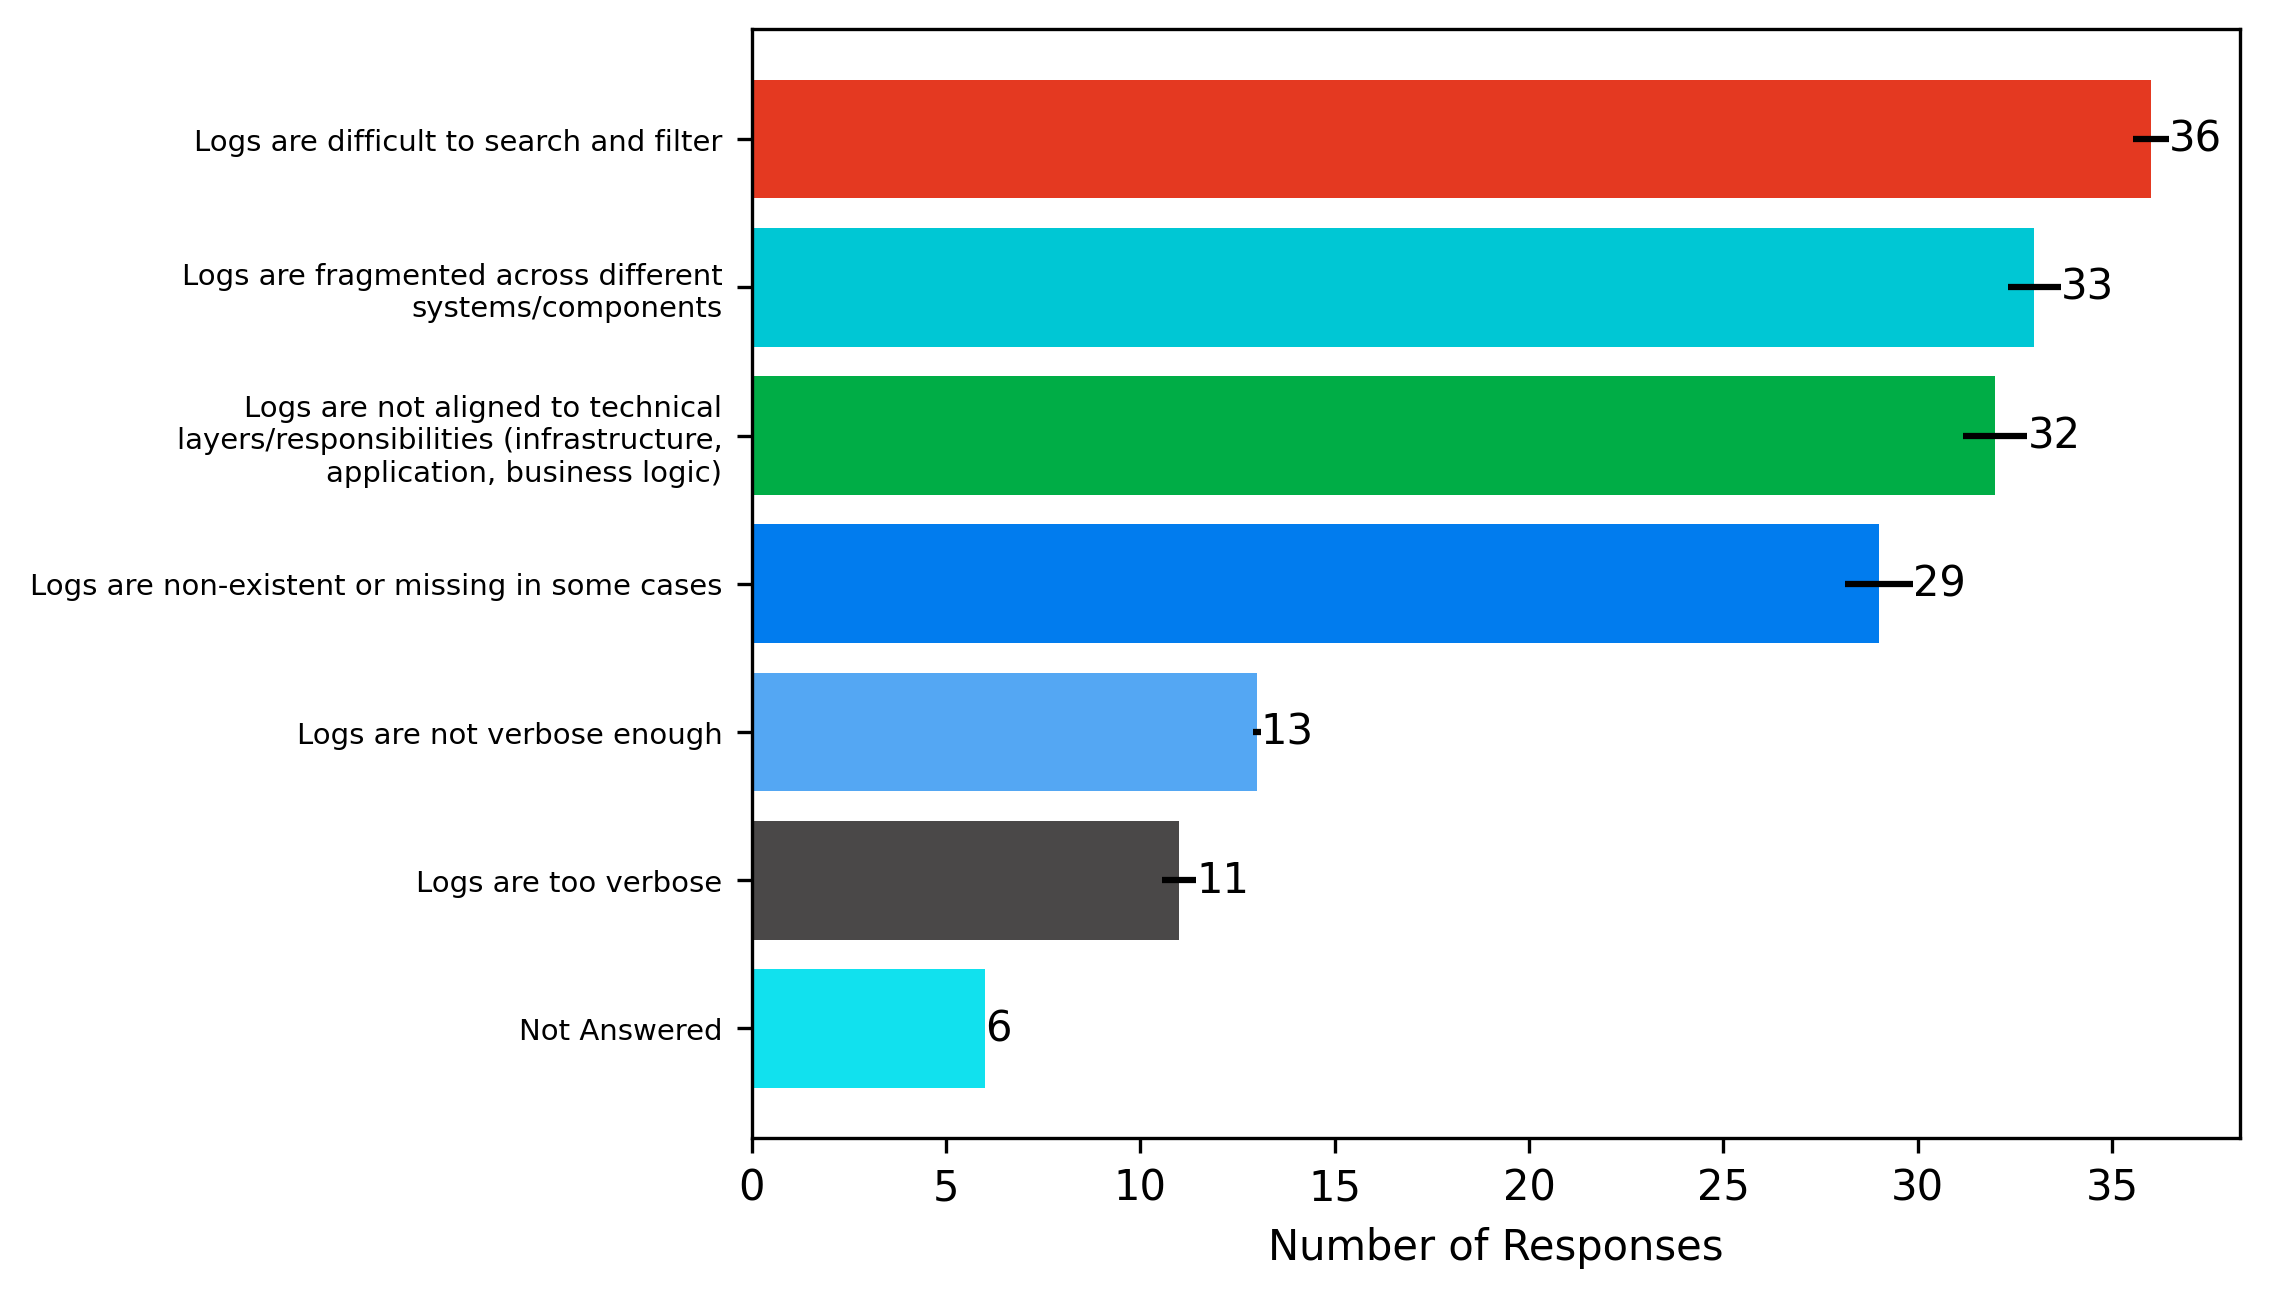

In [7]:
q11_opts = [
    "Logs are fragmented across different systems/components",
    "Logs are not verbose enough",
    "Logs are too verbose",
    "Logs are non-existent or missing in some cases",
    "Logs are difficult to search and filter",
    "Logs are not aligned to technical layers/responsibilities (infrastructure, application, business logic)"
]
q11_res = survey_df["1.1. What issues have you encountered with Airflow logs?"].tolist()
plot_checkbox_question_bar(q11_opts, q11_res)

# Q1.2. What challenges have you been facing with Airflow's stack traces?

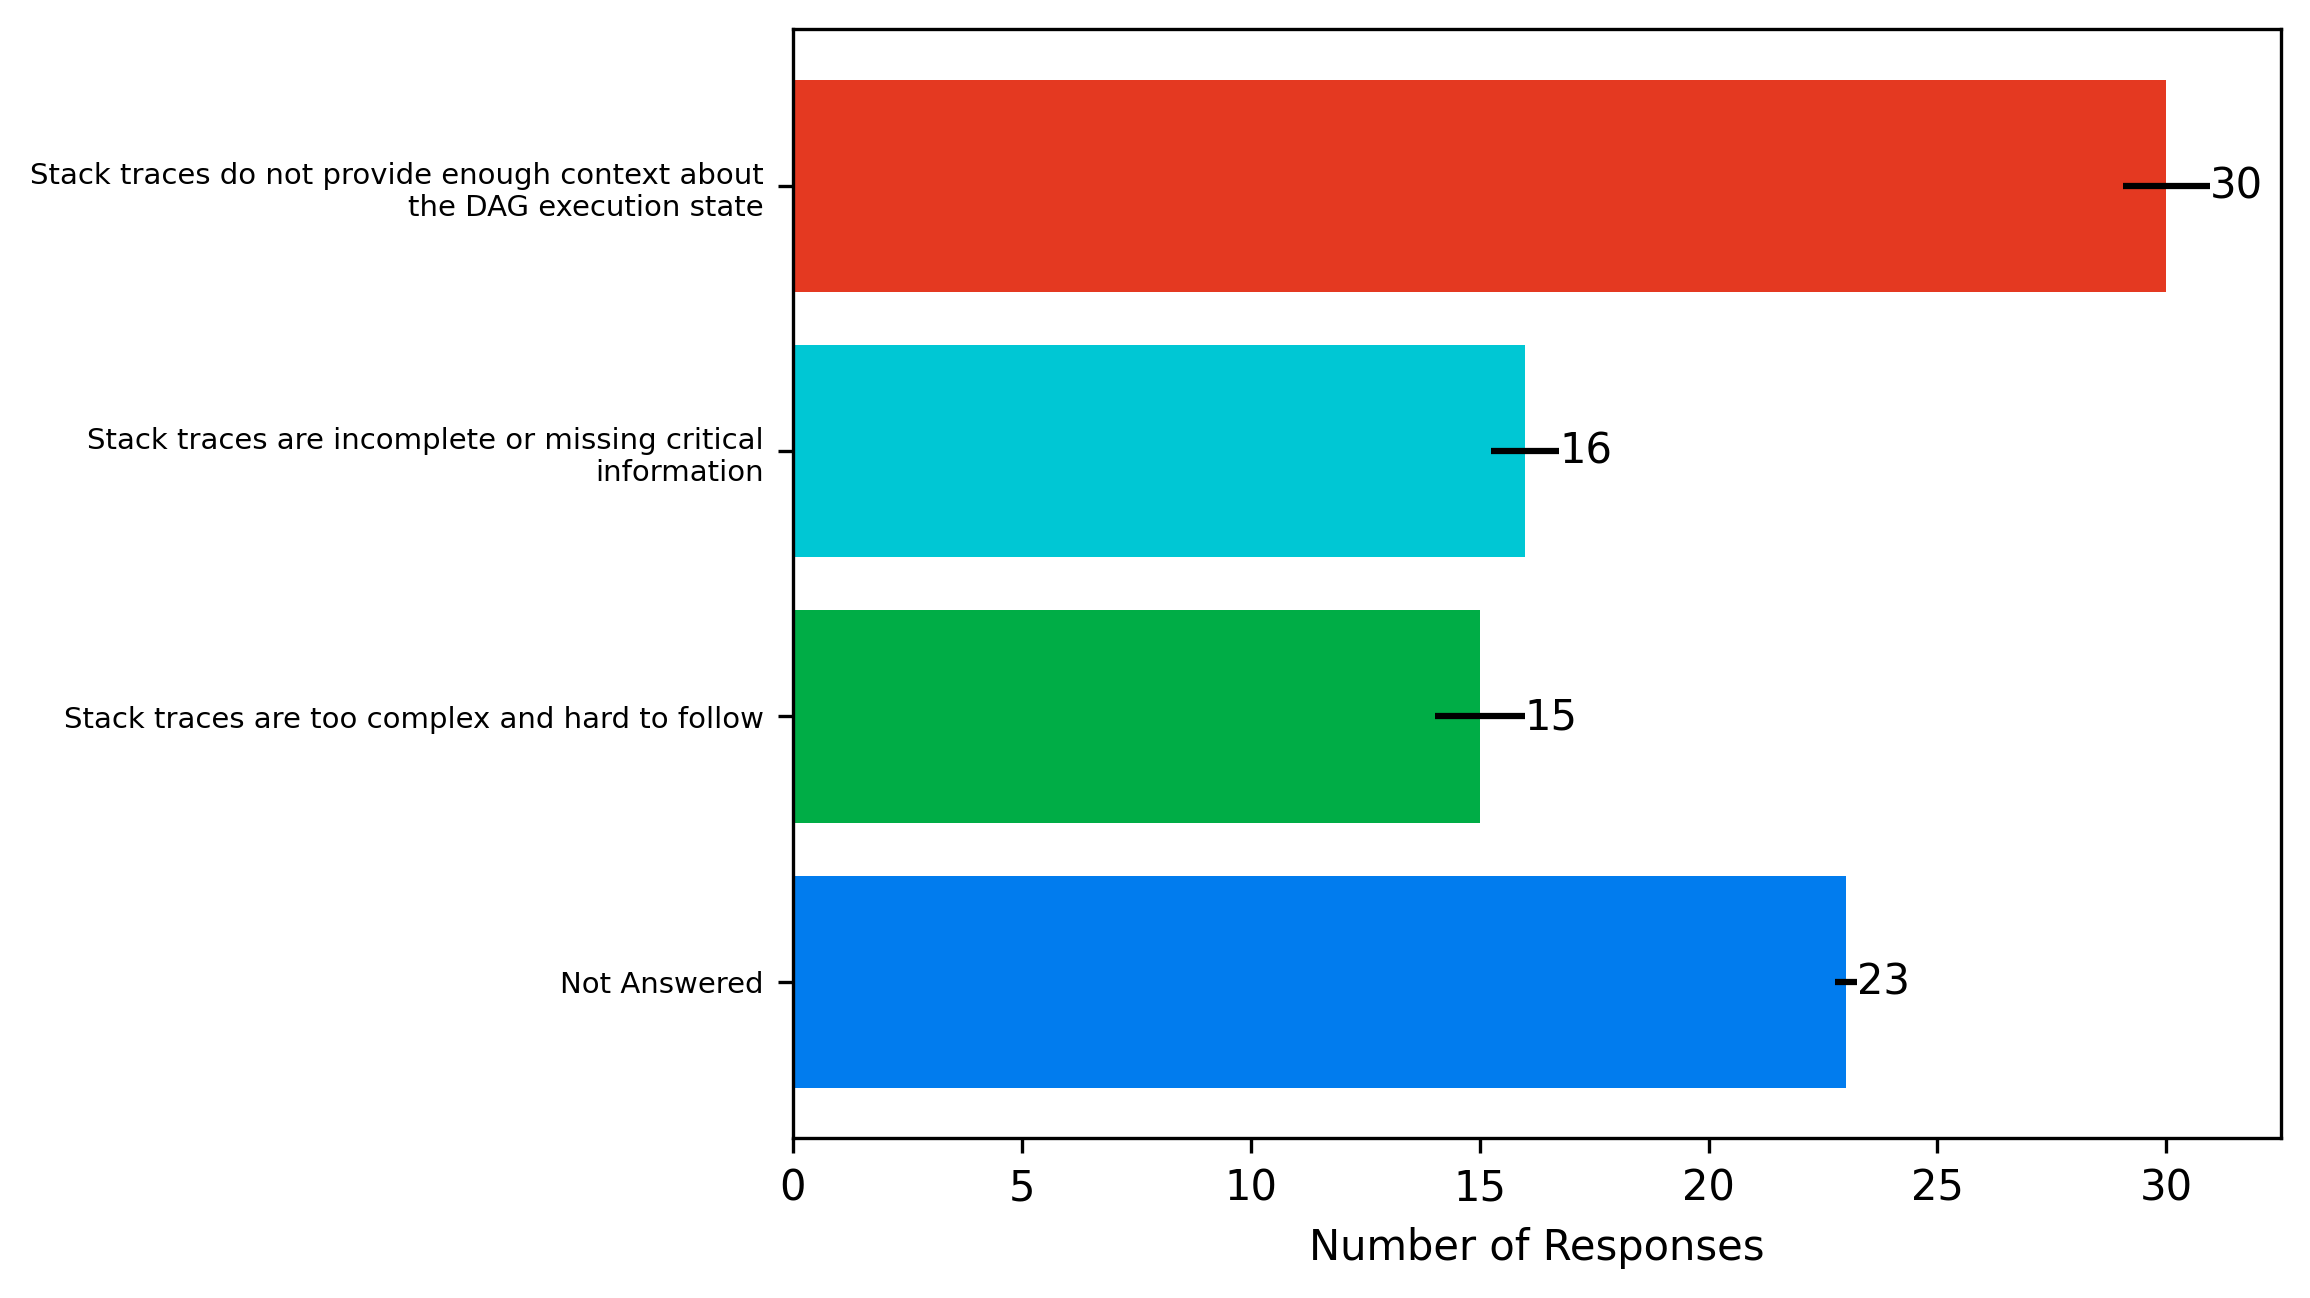

In [8]:
q12_opts = [
    "Stack traces are too complex and hard to follow",
    "Stack traces are incomplete or missing critical information",
    "Stack traces do not provide enough context about the DAG execution state",
]
q12_res = survey_df["1.2. What challenges have you been facing with Airflow's stack traces?"].tolist()
plot_checkbox_question_bar(q12_opts, q12_res)

# Q1.2.1. Other challenges:

In [9]:
# markdown_print(survey_df, "1.2.1. Other challenges:")
markdown_raw_print("""
DAG Parsing Issues:

    Some DAGs that run successfully as Python files are not parsed correctly by the DAG processor.

Stack Trace Effectiveness:

    Generally, stack traces are helpful and point to the right locations in the source code, especially when tasks are executed within the Airflow layer.

Stack Trace Control:

    Desire for more control over stack trace verbosity, possibly through a configurable property to adjust the length.

Error Clarity:

    Frustration with vague errors like "Celery command failed on host," which are often linked to DAG processor timeouts.

Complexity in Scheduler and Webserver Interaction:

    Difficulty connecting the scheduler and webserver due to a lack of visual trace information from the scheduler.

Incomplete Stack Traces:

    Stack traces do not always show the full path of the source file, which can lead to confusion with files that have the same name across installed packages.
    Stack traces for failing DAGs often lack complete information when displayed in the UI's red error bar.
""")

### DAG Parsing Issues:

- Some DAGs that run successfully as Python files are not parsed correctly by the DAG processor.

### Stack Trace Effectiveness:

- Generally, stack traces are helpful and point to the right locations in the source code, especially when tasks are executed within the Airflow layer.

### Stack Trace Control:

- Desire for more control over stack trace verbosity, possibly through a configurable property to adjust the length.

### Error Clarity:

- Frustration with vague errors like "Celery command failed on host," which are often linked to DAG processor timeouts.

### Complexity in Scheduler and Webserver Interaction:

- Difficulty connecting the scheduler and webserver due to a lack of visual trace information from the scheduler.

### Incomplete Stack Traces:

- Stack traces do not always show the full path of the source file, which can lead to confusion with files that have the same name across installed packages.

- Stack traces for failing DAGs often lack complete information when displayed in the UI's red error bar.

# Q1.3. How would you rate the ease of understanding stack traces in Airflow?

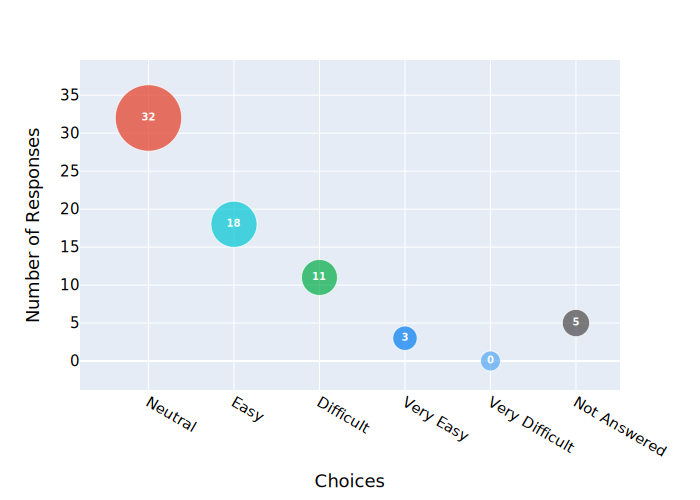

In [10]:
q13_opts = {
    "1": "Very Difficult",
    "2": "Difficult",
    "3": "Neutral",
    "4": "Easy",
    "5": "Very Easy",
    "Not Answered": "Not Answered"
}
q13_res = survey_df["1.3. How would you rate the ease of understanding stack traces in Airflow?"].tolist()
plot_checkbox_question_dotplot(q13_opts, q13_res)

# Q1.4. What improvements to Airflow’s traceback information would make debugging easier?

In [11]:
# markdown_print(survey_df, "1.4. What improvements to Airflow’s traceback information would make debugging easier?")
markdown_raw_print("""
Log Readability and Features:

    Implement color coding based on criticality to enhance log readability.
    Improve log searching and readability using colors and UI features.

Error Clarity:

    Multiple exceptions can confuse users; clearer presentation is needed.
    Stack traces are generally helpful but can be misleading when they arise from dependency conflicts after upgrades.

Feedback Suggestions:

    Highlight hyperlinks in logs (e.g., links to Spark jobs) and color code error logs for better visibility.
    Provide a one-liner explanation of errors and create separate error pages with filters and detailed visual presentations.

DAG Context in Errors:

    Include the parsed version of the DAG during errors to clarify the state of the code at the time of failure, especially if the DAG has been updated.

DAG Execution State:

    Elaborate on DAG execution states beyond just the log line that failed; more context about checks at the time of the failure is needed, particularly in the scheduler.

Stack Trace Improvements:

    Provide dependency tracking in stack traces, showing upstream and downstream tasks and their states.
    Automatically dump relevant variables and environment states at the time of failure, including task parameters and Airflow configurations.
    Add time information to stack traces, detailing the time spent on different operations within a task.

Failure Warnings:

    Include warnings in tracebacks for steps that take unusually long before failing, such as long-running database queries.
""")

### Log Readability and Features:

- Implement color coding based on criticality to enhance log readability.

- Improve log searching and readability using colors and UI features.

### Error Clarity:

- Multiple exceptions can confuse users; clearer presentation is needed.

- Stack traces are generally helpful but can be misleading when they arise from dependency conflicts after upgrades.

### Feedback Suggestions:

- Highlight hyperlinks in logs (e.g., links to Spark jobs) and color code error logs for better visibility.

- Provide a one-liner explanation of errors and create separate error pages with filters and detailed visual presentations.

### DAG Context in Errors:

- Include the parsed version of the DAG during errors to clarify the state of the code at the time of failure, especially if the DAG has been updated.

### DAG Execution State:

- Elaborate on DAG execution states beyond just the log line that failed; more context about checks at the time of the failure is needed, particularly in the scheduler.

### Stack Trace Improvements:

- Provide dependency tracking in stack traces, showing upstream and downstream tasks and their states.

- Automatically dump relevant variables and environment states at the time of failure, including task parameters and Airflow configurations.

- Add time information to stack traces, detailing the time spent on different operations within a task.

### Failure Warnings:

- Include warnings in tracebacks for steps that take unusually long before failing, such as long-running database queries.

# Q1.4.1. Potential improvements:

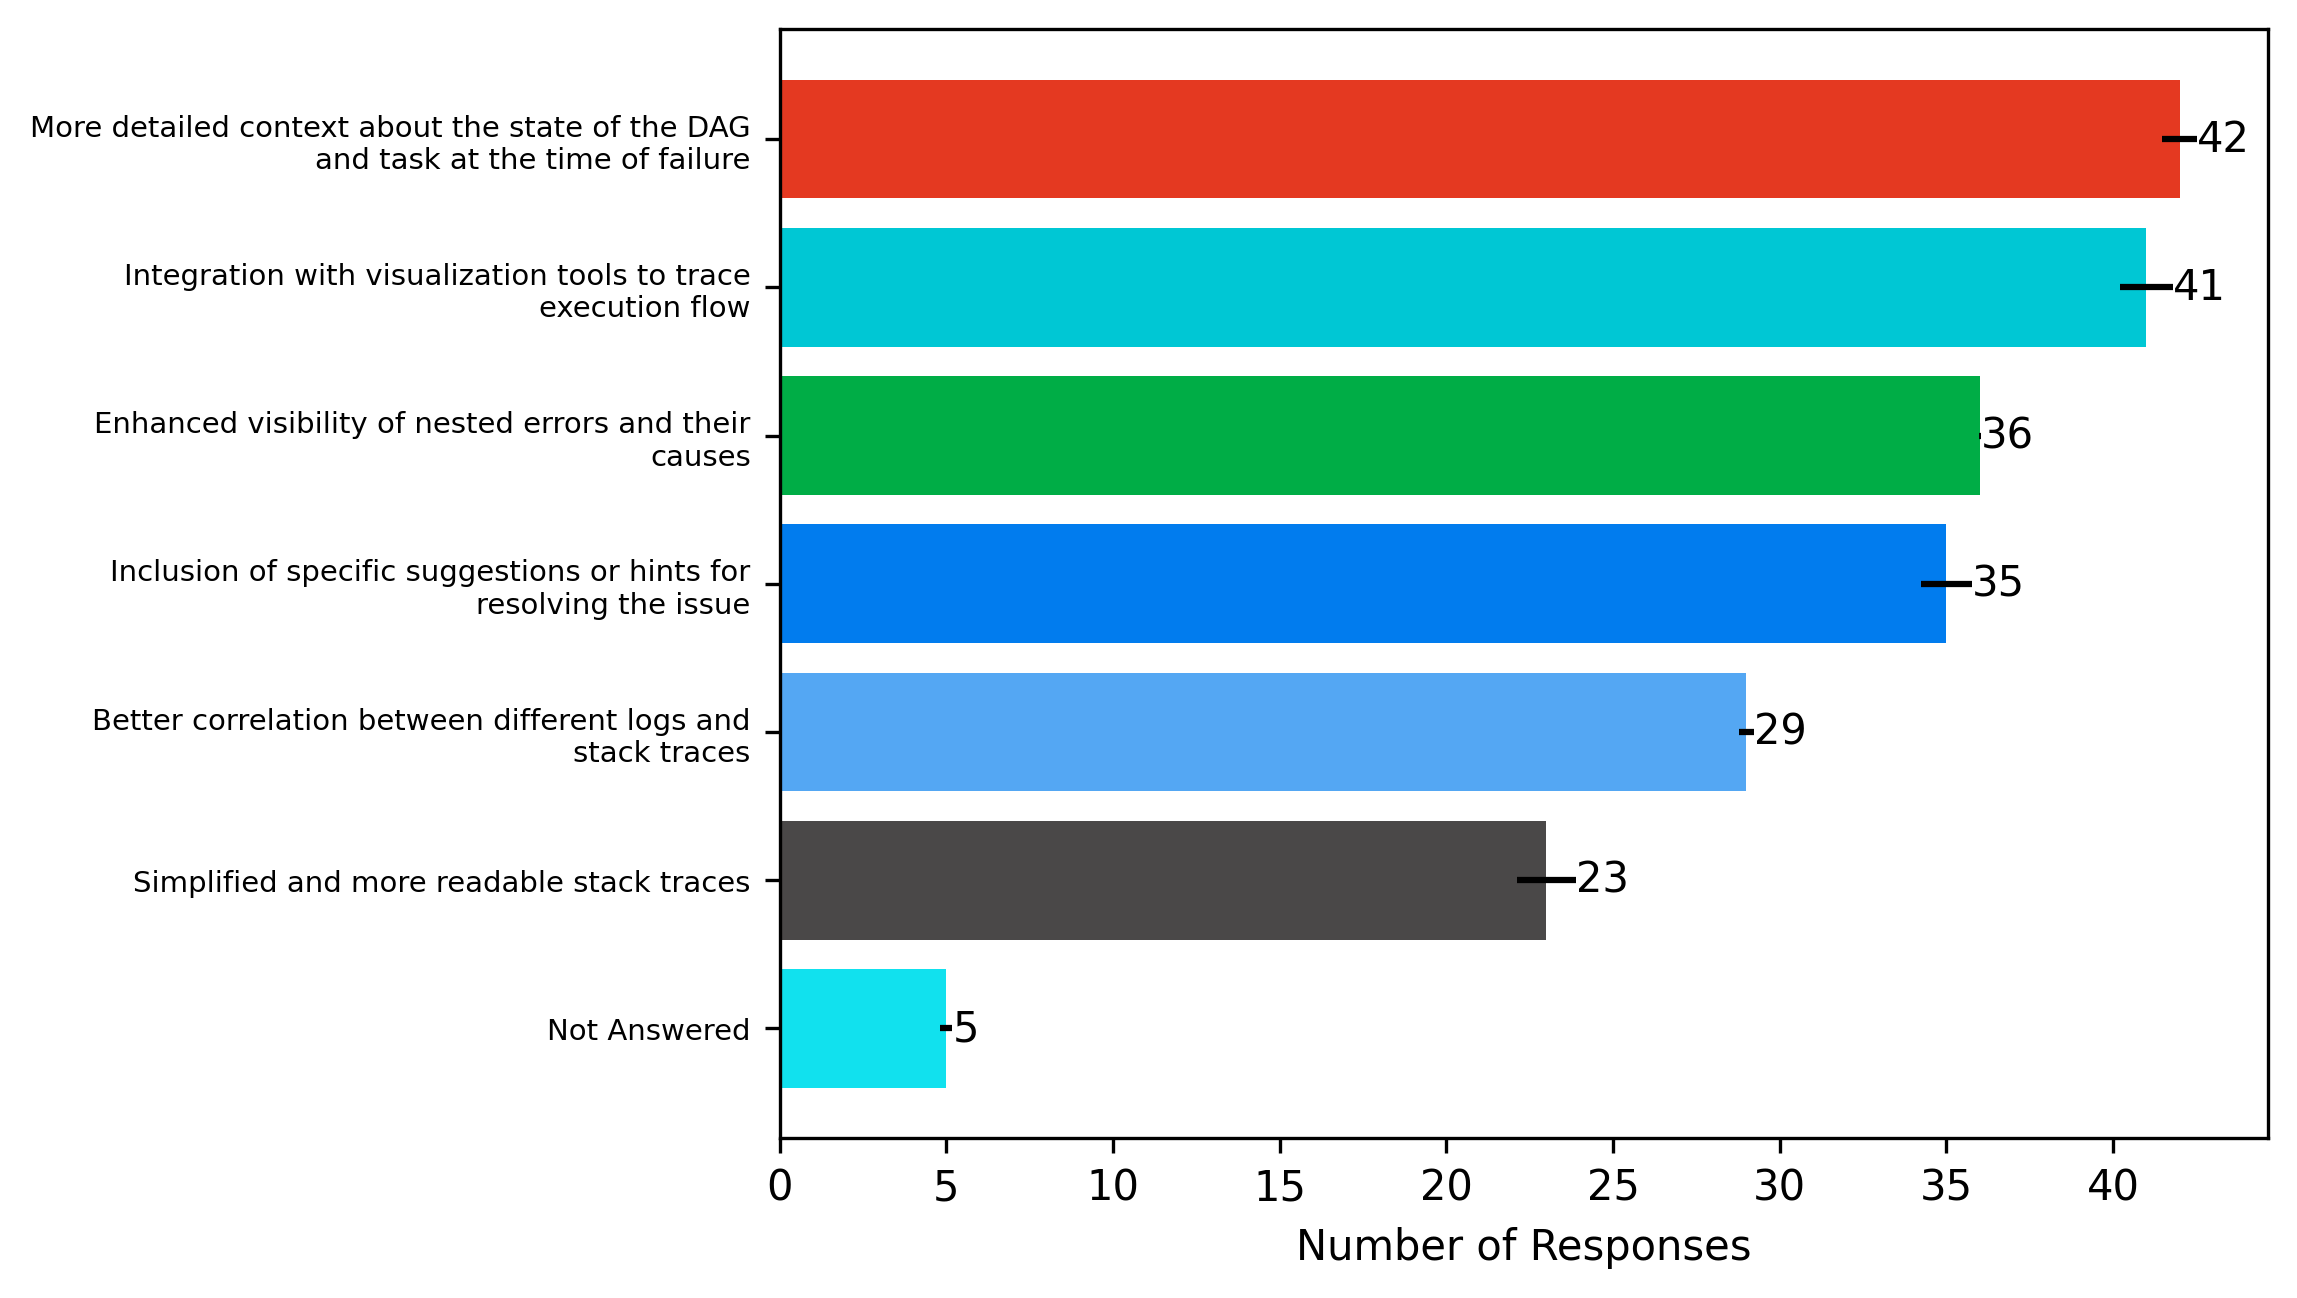

In [12]:
q141_opts = [
    "Simplified and more readable stack traces",
    "More detailed context about the state of the DAG and task at the time of failure",
    "Better correlation between different logs and stack traces",
    "Inclusion of specific suggestions or hints for resolving the issue",
    "Enhanced visibility of nested errors and their causes",
    "Integration with visualization tools to trace execution flow",
]
q141_res = survey_df["1.4.1. Potential improvements:"].tolist()
plot_checkbox_question_bar(q141_opts, q141_res)

# Q2.1. What issues have you encountered with Airflow error messages?

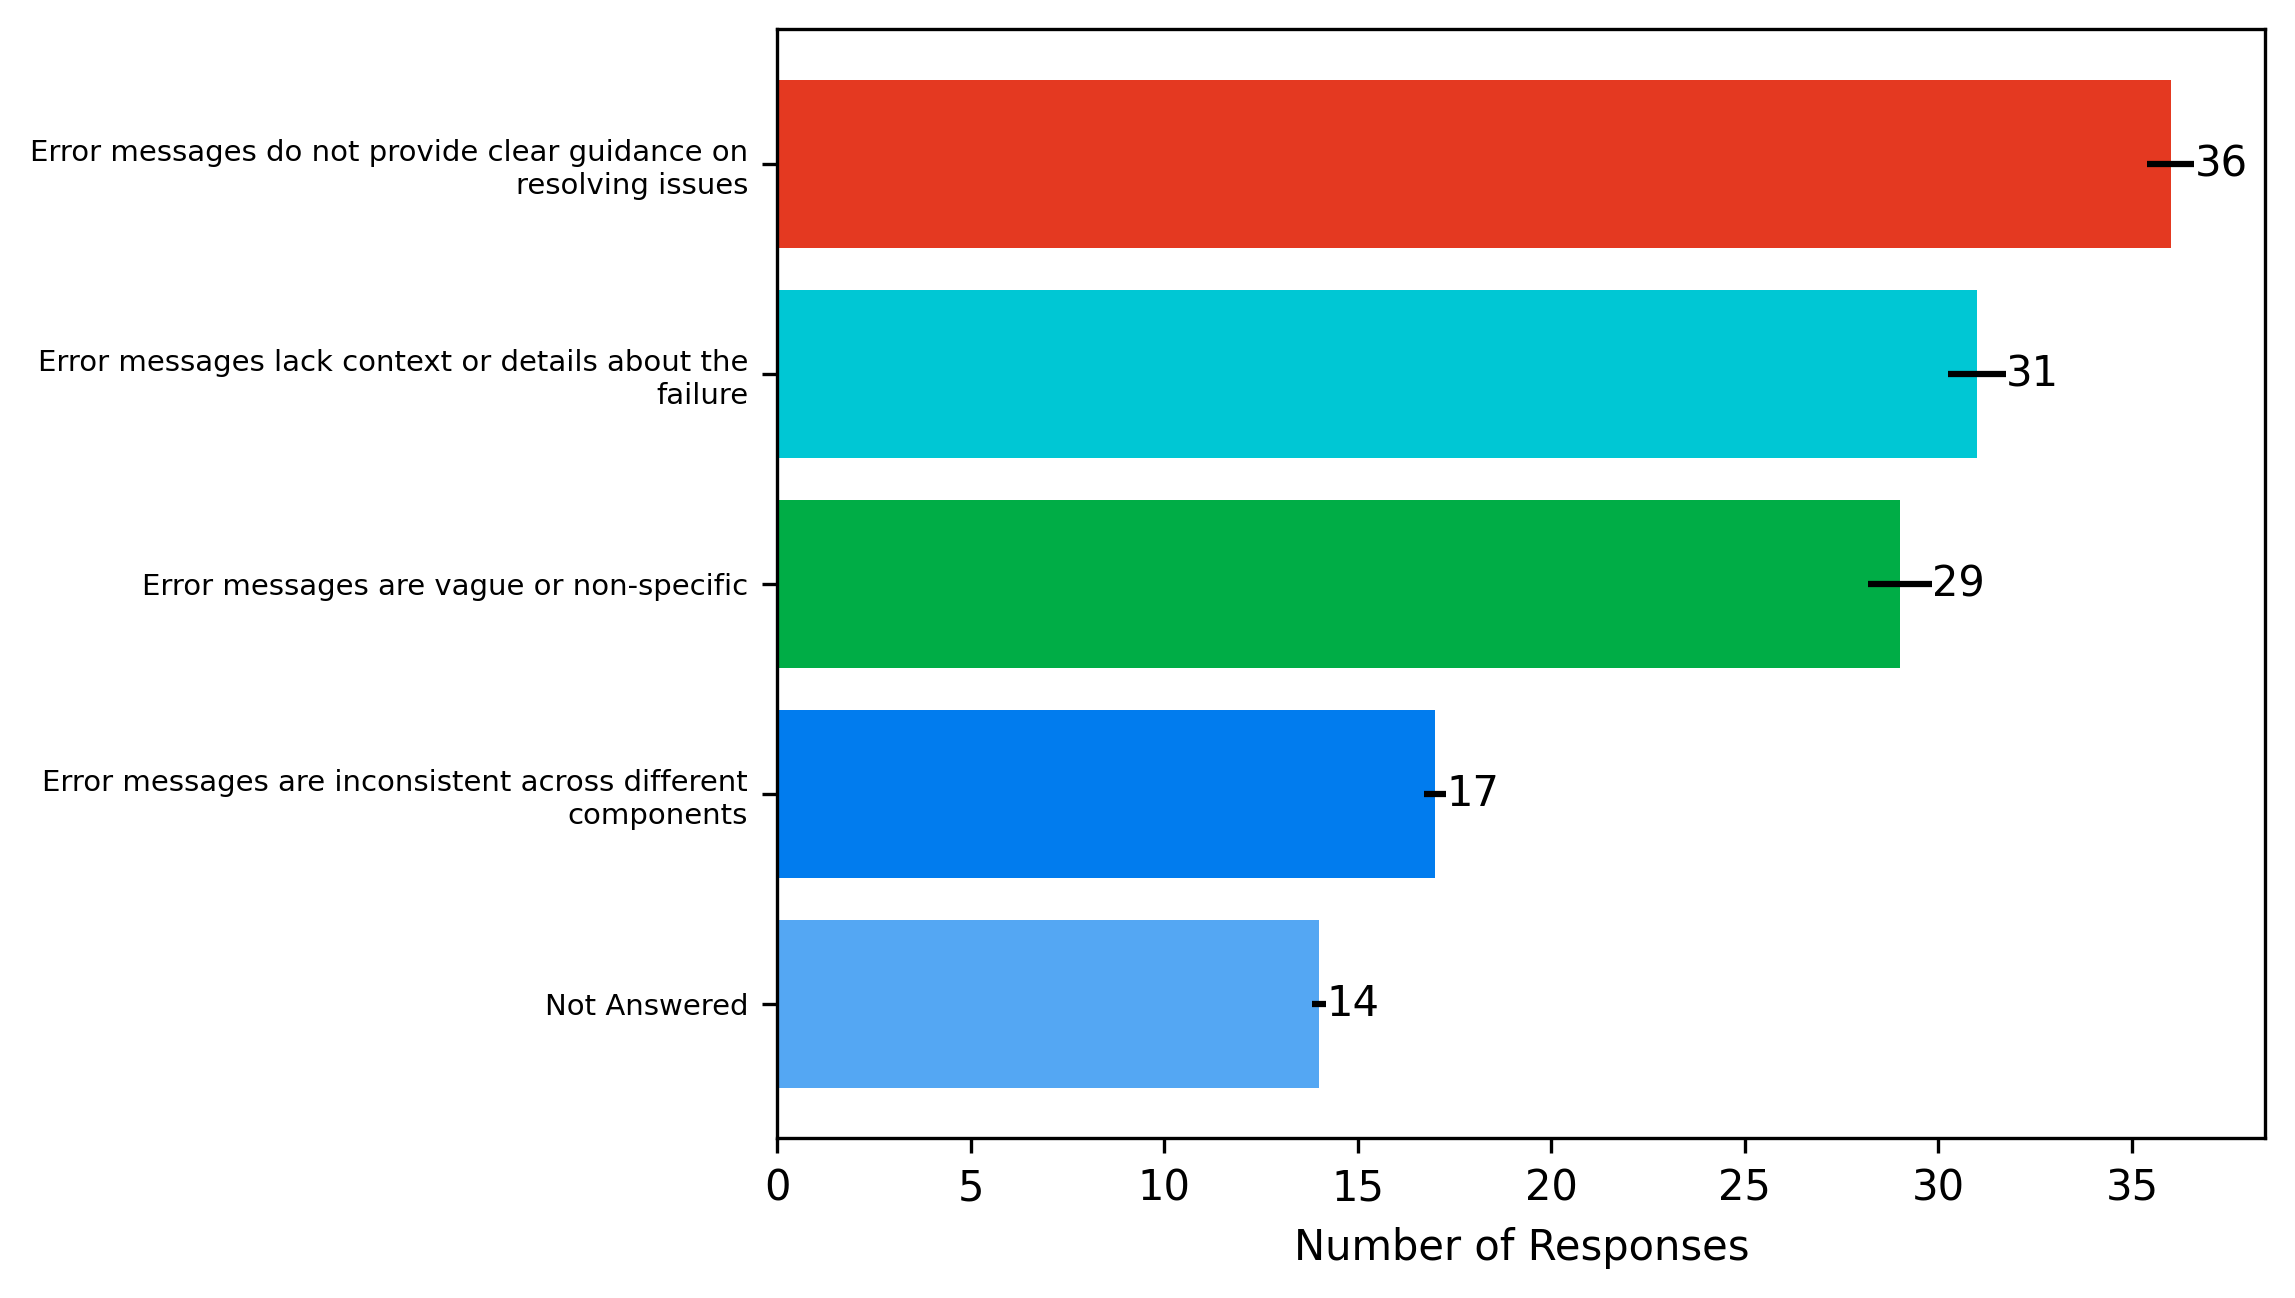

In [13]:
q21_opts = [
    "Error messages are vague or non-specific",
    "Error messages do not provide clear guidance on resolving issues",
    "Error messages lack context or details about the failure",
    "Error messages are inconsistent across different components",
]
q21_res = survey_df["2.1. What issues have you encountered with Airflow error messages?"].tolist()
plot_checkbox_question_bar(q21_opts, q21_res)

# Q2.2. How would you rate the clarity & actionability of Airflow error messages?

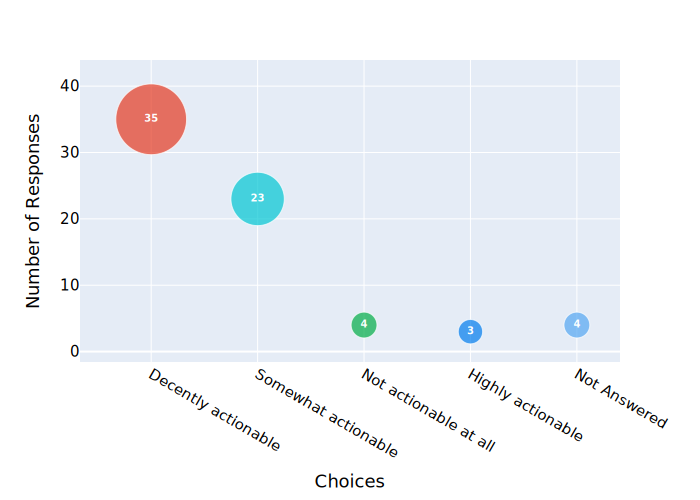

In [14]:
q22_opts = {
    "1": "Not actionable at all",
    "2": "Somewhat actionable",
    "3": "Decently actionable",
    "4": "Highly actionable",
    "Not Answered": "Not Answered",
}
q22_res = survey_df["2.2. How would you rate the clarity & actionability of Airflow error messages?"].tolist()
plot_checkbox_question_dotplot(q22_opts, q22_res)

# Q2.3. Which of the following suggestions would improve Airflow's error handling?

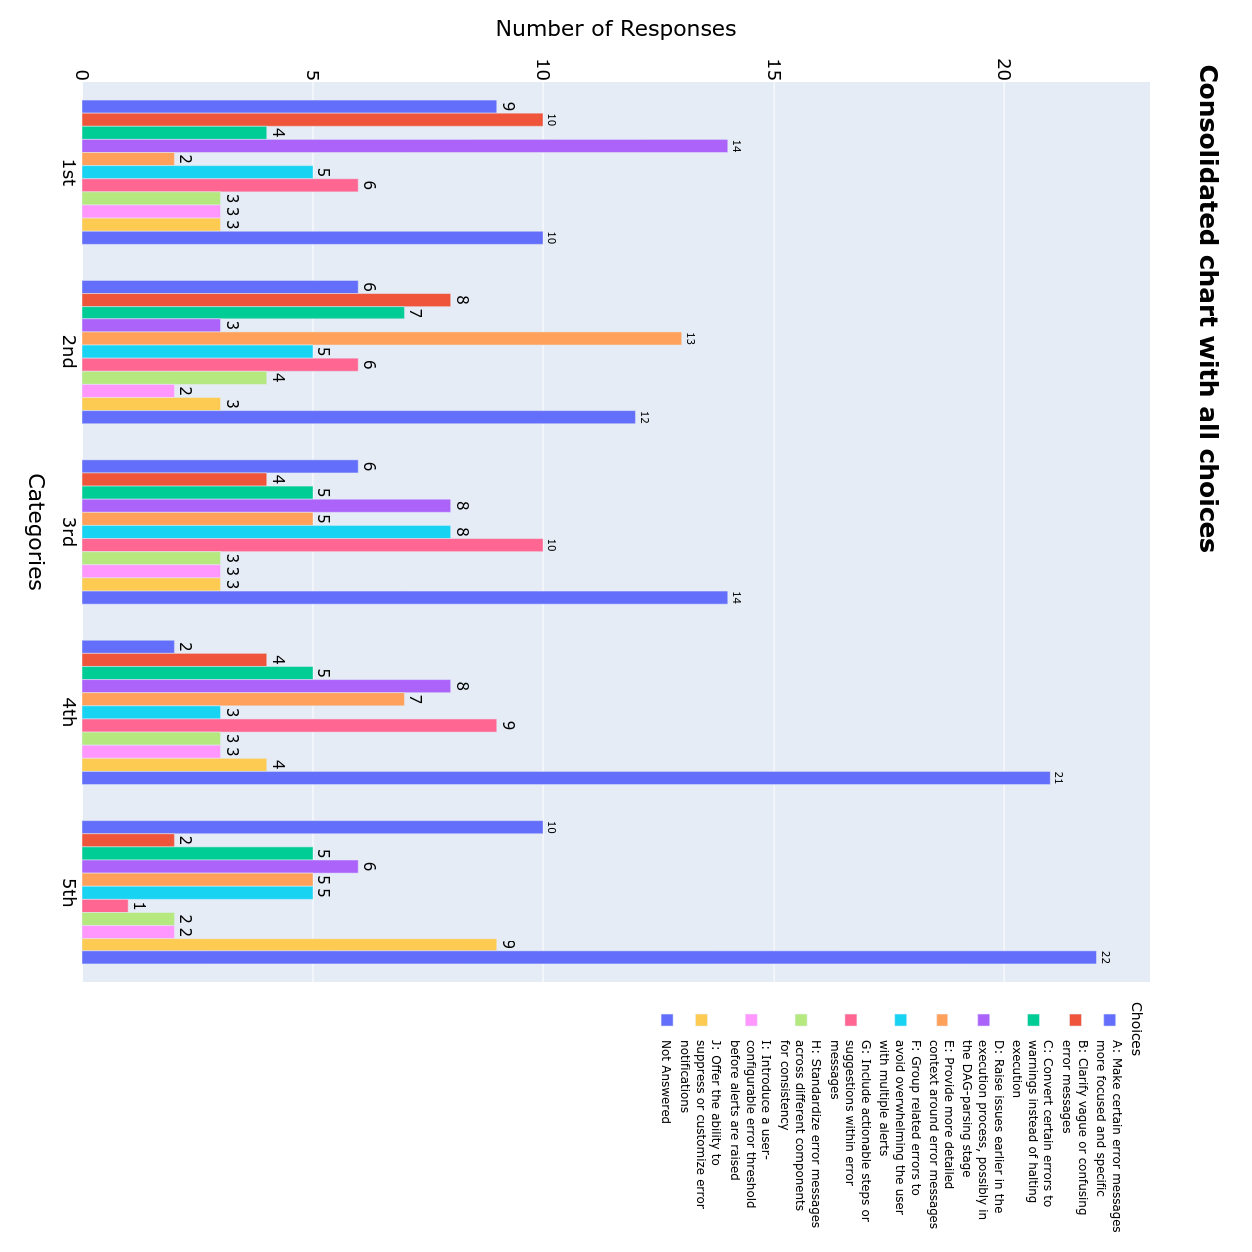

In [15]:
base_question = "2.3. Which of the following suggestions would improve Airflow's error handling?"
q23_opts = {
    "A": "Make certain error messages more focused and specific",
    "B": "Clarify vague or confusing error messages",
    "C": "Convert certain errors to warnings instead of halting execution",
    "D": "Raise issues earlier in the execution process, possibly in the DAG-parsing stage",
    "E": "Provide more detailed context around error messages",
    "F": "Group related errors to avoid overwhelming the user with multiple alerts",
    "G": "Include actionable steps or suggestions within error messages",
    "H": "Standardize error messages across different components for consistency",
    "I": "Introduce a user-configurable error threshold before alerts are raised",
    "J": "Offer the ability to suppress or customize error notifications",
    "Not Answered": "Not Answered",
}
plot_multichoice_question(survey_df, base_question, q23_opts, num_ranks=5)

# Q3.1. Which tools do you use to develop Airflow DAGs?

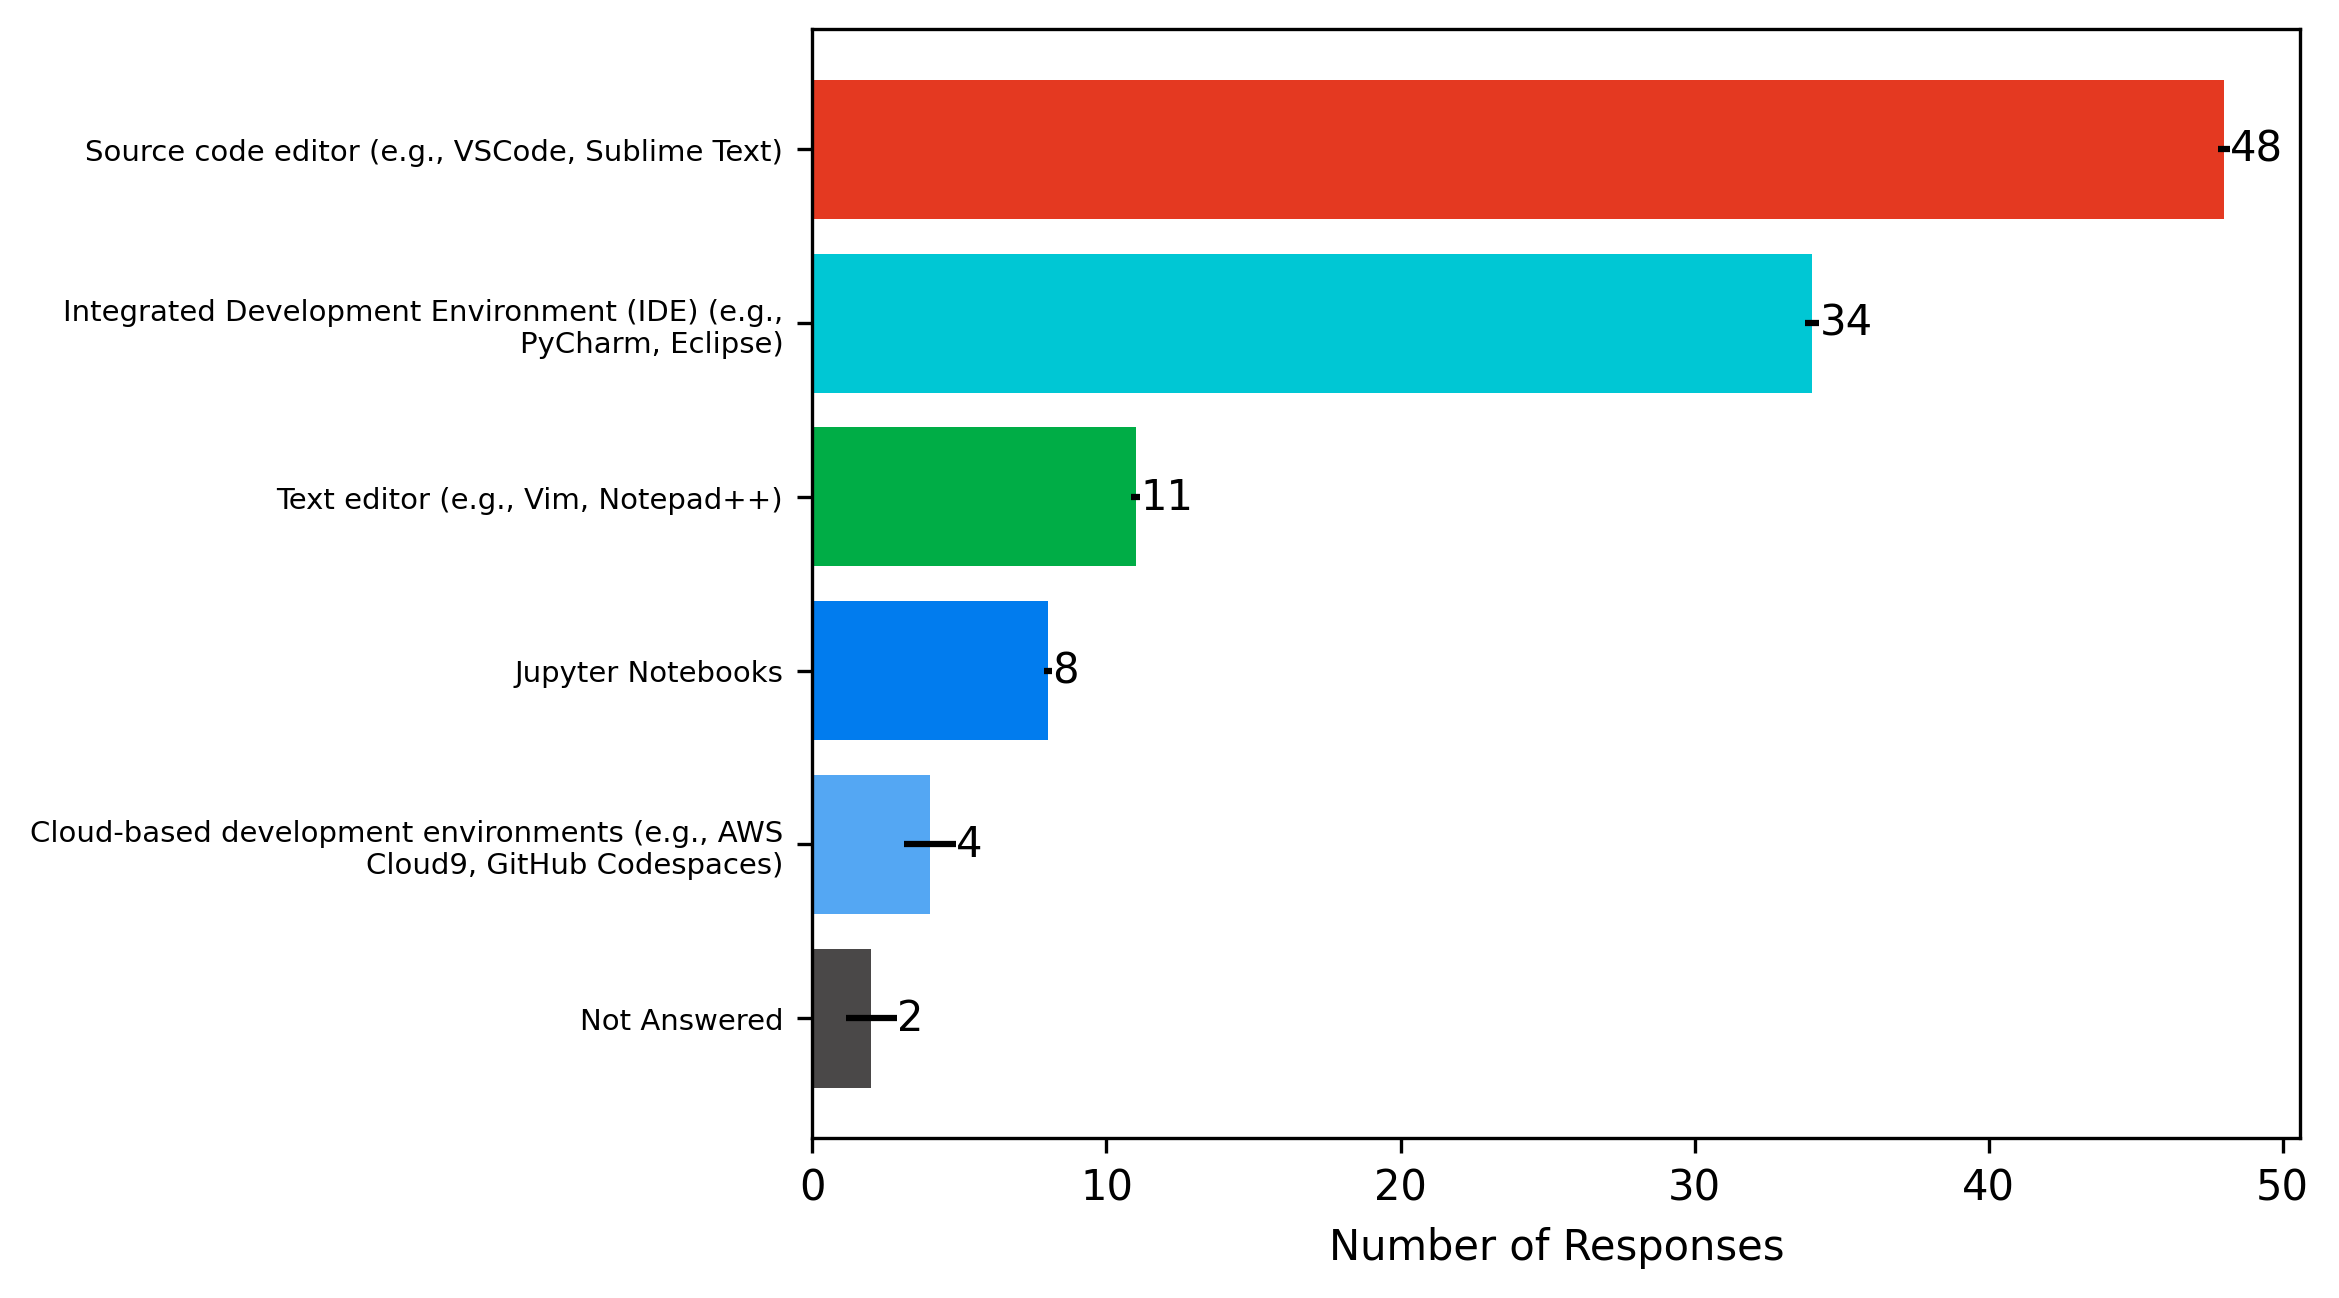

In [16]:
q31_opts = [
    "Text editor (e.g., Vim, Notepad++)",
    "Source code editor (e.g., VSCode, Sublime Text)",
    "Integrated Development Environment (IDE) (e.g., PyCharm, Eclipse)",
    "Jupyter Notebooks",
    "Cloud-based development environments (e.g., AWS Cloud9, GitHub Codespaces)",
]
q31_res = survey_df["3.1. Which tools do you use to develop Airflow DAGs?"].tolist()
plot_checkbox_question_bar(q31_opts, q31_res)

# Q3.2. How satisfied are you with Airflow’s integration with modern debugging tools and the related documentation?

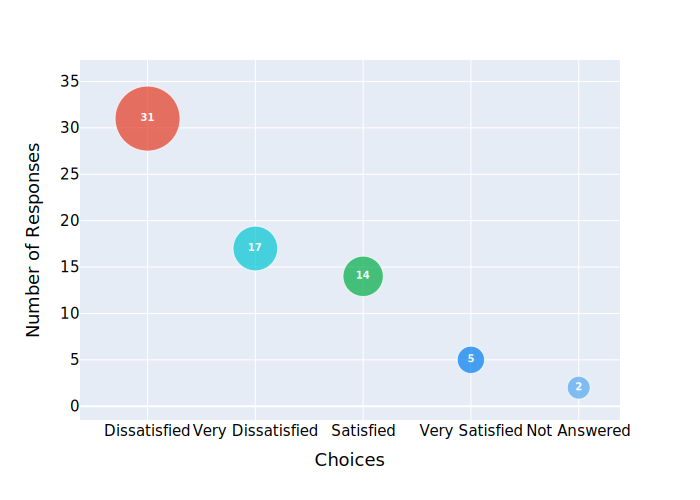

In [17]:
q32_opts = {
    "1": "Very Dissatisfied",
    "2": "Dissatisfied",
    "3": "Satisfied",
    "4": "Very Satisfied",
    "Not Answered": "Not Answered"
}
q32_res = survey_df["3.2. How satisfied are you with Airflow’s integration with modern debugging tools and the related documentation?"].tolist()
plot_checkbox_question_dotplot(q32_opts, q32_res)

# Q3.3. How often do you use external tools (i.e. besides Airflow's API, UI, and CLI) to supplement Airflow's debugging capabilities?

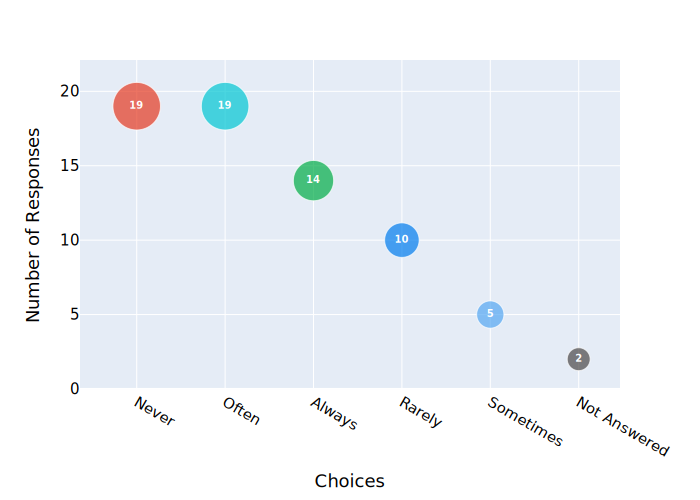

In [18]:
q33_opts = {
    "1": "Never",
    "2": "Rarely",
    "3": "Sometimes",
    "4": "Often",
    "5": "Always",
    "Not Answered": "Not Answered"
}
q33_res = survey_df["3.3. How often do you use external tools (i.e. besides Airflow's API, UI, and CLI) to supplement Airflow's debugging capabilities?"].tolist()
plot_checkbox_question_dotplot(q33_opts, q33_res)

# Q3.4. What sort of external tools do you use in conjunction with Airflow for debugging?

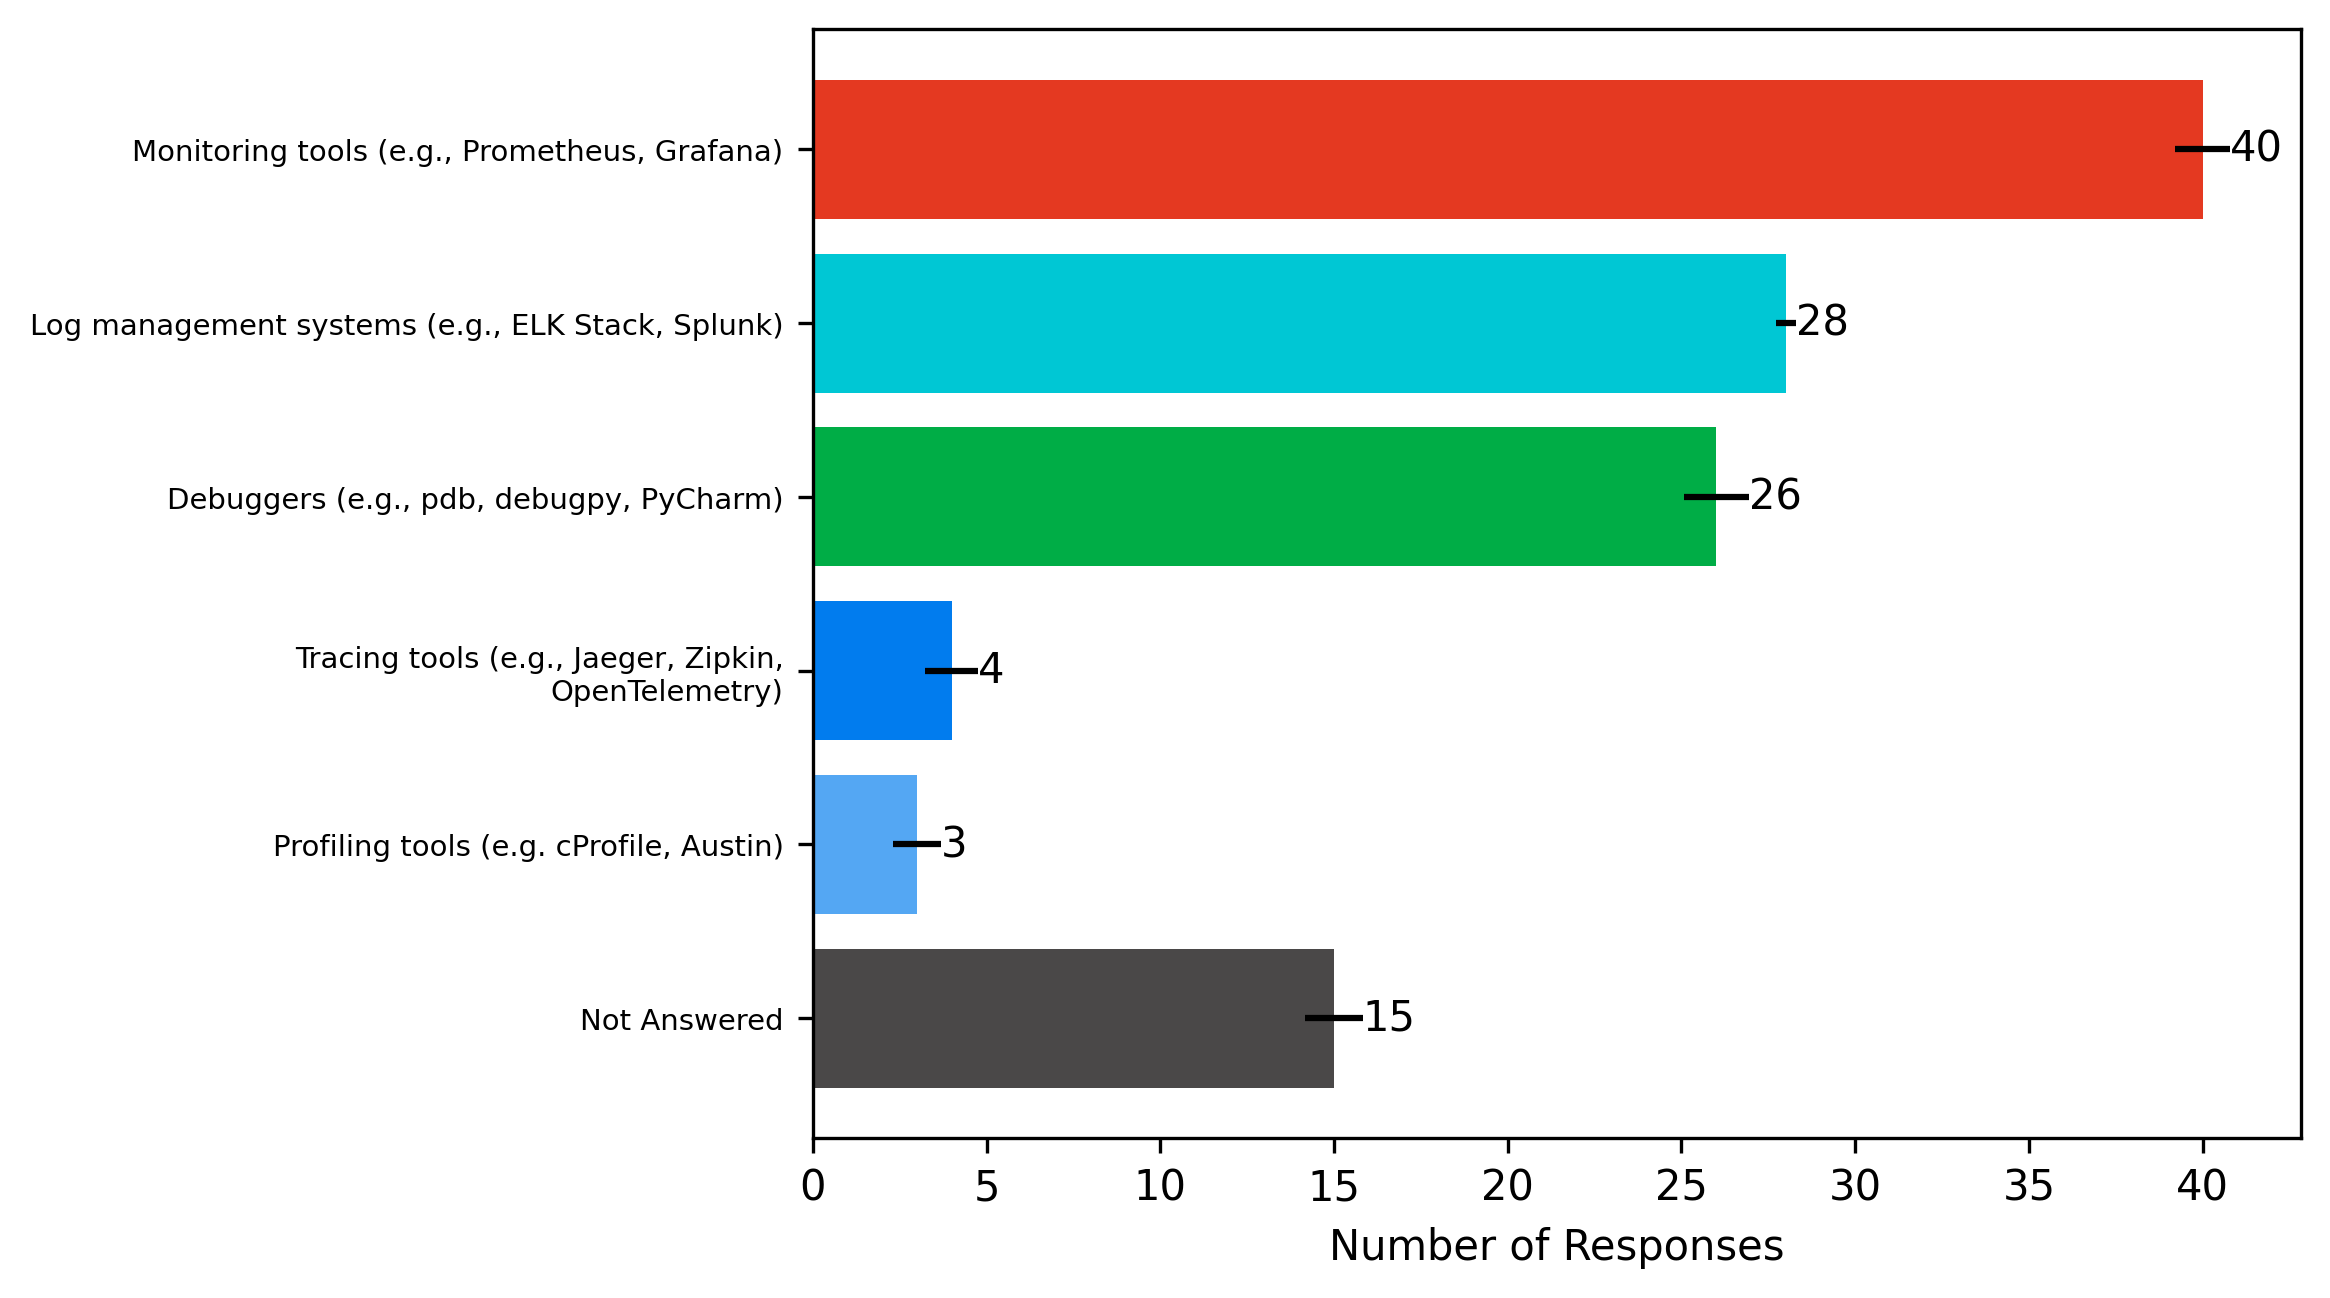

In [19]:
q34_opts = [
    "Log management systems (e.g., ELK Stack, Splunk)",
    "Monitoring tools (e.g., Prometheus, Grafana)",
    "Tracing tools (e.g., Jaeger, Zipkin, OpenTelemetry)",
    "Profiling tools (e.g. cProfile, Austin)",
    "Debuggers (e.g., pdb, debugpy, PyCharm)"
]
q34_res = survey_df["3.4. What sort of external tools do you use in conjunction with Airflow for debugging?"].tolist()
plot_checkbox_question_bar(q34_opts, q34_res)

# Q3.5. What integrations or tooling improvements would you like to see in Airflow to enhance your debugging experience?

In [20]:
# markdown_print(survey_df, "3.5. What integrations or tooling improvements would you like to see in Airflow to enhance your debugging experience?")
markdown_raw_print("""
Remote Debugging:

    Easier and better-documented attachment to remote Airflow instances.
    Support for remote debugging of tasks through VS Code.
    Full debugging of Airflow DAGs from start to finish.

Local Development and Debugging:

    Improved ease of running Airflow locally and integrating with the VS Code debugger.
    Support for debugging containerized Airflow stacks using Docker Compose.

Connection Improvements:

    Transition from TCP to HTTP connections for better robustness between remote workers and the cloud.

Cluster Activity Tab:

    Potential for enhanced overview capabilities of all DAGs within the cluster activity tab.

Variables and Connections Documentation:

    Need for clearer documentation on setting up Airflow variables and connections for debugging (e.g., during dag.test() sessions) with various formats (CLI, YAML, JSON, etc.).

VS Code Extensions:

    Extension for parsing DAGs and improved integrations with log management tools (e.g., logz.io) and monitoring tools.

Debugging Support:

    More robust support for debugging, considering the tightly coupled nature of Airflow that complicates debugging without a fully initialized environment.

IDE Features:

    Desktop IDE debugging support in VS Code and a specific PyCharm plugin for Airflow testing and debugging.
    Linting and formatting tools, as well as a PyCharm plugin for DAG integrity testing and visualization.

Online IDE Functionality:

    Online IDE or developer mode for adding debuggers and breakpoints on the fly.

Memory Monitoring:

    Tools to accurately monitor memory usage on a task-by-task basis.

Kubernetes Debugging:

    Improved tooling for attaching debuggers to Kubernetes pods in local development environments.

Testing Improvements:

    Desire for testing tasks as standalone methods without the Airflow wrapper complicating the process.

Feedback and Features:

    Integration with remote debuggers for live environments, and a built-in task-level debugging console within the Airflow UI to inspect task states and outputs.

Local Airflow Enhancements:

    Better support for running Airflow locally, including 'airflow standalone' functionality with MySQL or PostgreSQL, similar to SQLite, to avoid concurrency issues.
""")

### Remote Debugging:

- Easier and better-documented attachment to remote Airflow instances.

- Support for remote debugging of tasks through VS Code.

- Full debugging of Airflow DAGs from start to finish.

### Local Development and Debugging:

- Improved ease of running Airflow locally and integrating with the VS Code debugger.

- Support for debugging containerized Airflow stacks using Docker Compose.

### Connection Improvements:

- Transition from TCP to HTTP connections for better robustness between remote workers and the cloud.

### Cluster Activity Tab:

- Potential for enhanced overview capabilities of all DAGs within the cluster activity tab.

### Variables and Connections Documentation:

- Need for clearer documentation on setting up Airflow variables and connections for debugging (e.g., during dag.test() sessions) with various formats (CLI, YAML, JSON, etc.).

### VS Code Extensions:

- Extension for parsing DAGs and improved integrations with log management tools (e.g., logz.io) and monitoring tools.

### Debugging Support:

- More robust support for debugging, considering the tightly coupled nature of Airflow that complicates debugging without a fully initialized environment.

### IDE Features:

- Desktop IDE debugging support in VS Code and a specific PyCharm plugin for Airflow testing and debugging.

- Linting and formatting tools, as well as a PyCharm plugin for DAG integrity testing and visualization.

### Online IDE Functionality:

- Online IDE or developer mode for adding debuggers and breakpoints on the fly.

### Memory Monitoring:

- Tools to accurately monitor memory usage on a task-by-task basis.

### Kubernetes Debugging:

- Improved tooling for attaching debuggers to Kubernetes pods in local development environments.

### Testing Improvements:

- Desire for testing tasks as standalone methods without the Airflow wrapper complicating the process.

### Feedback and Features:

- Integration with remote debuggers for live environments, and a built-in task-level debugging console within the Airflow UI to inspect task states and outputs.

### Local Airflow Enhancements:

- Better support for running Airflow locally, including 'airflow standalone' functionality with MySQL or PostgreSQL, similar to SQLite, to avoid concurrency issues.

# Q3.6. Which of the following code assistance and inspection tools do you use while developing Airflow DAGs?

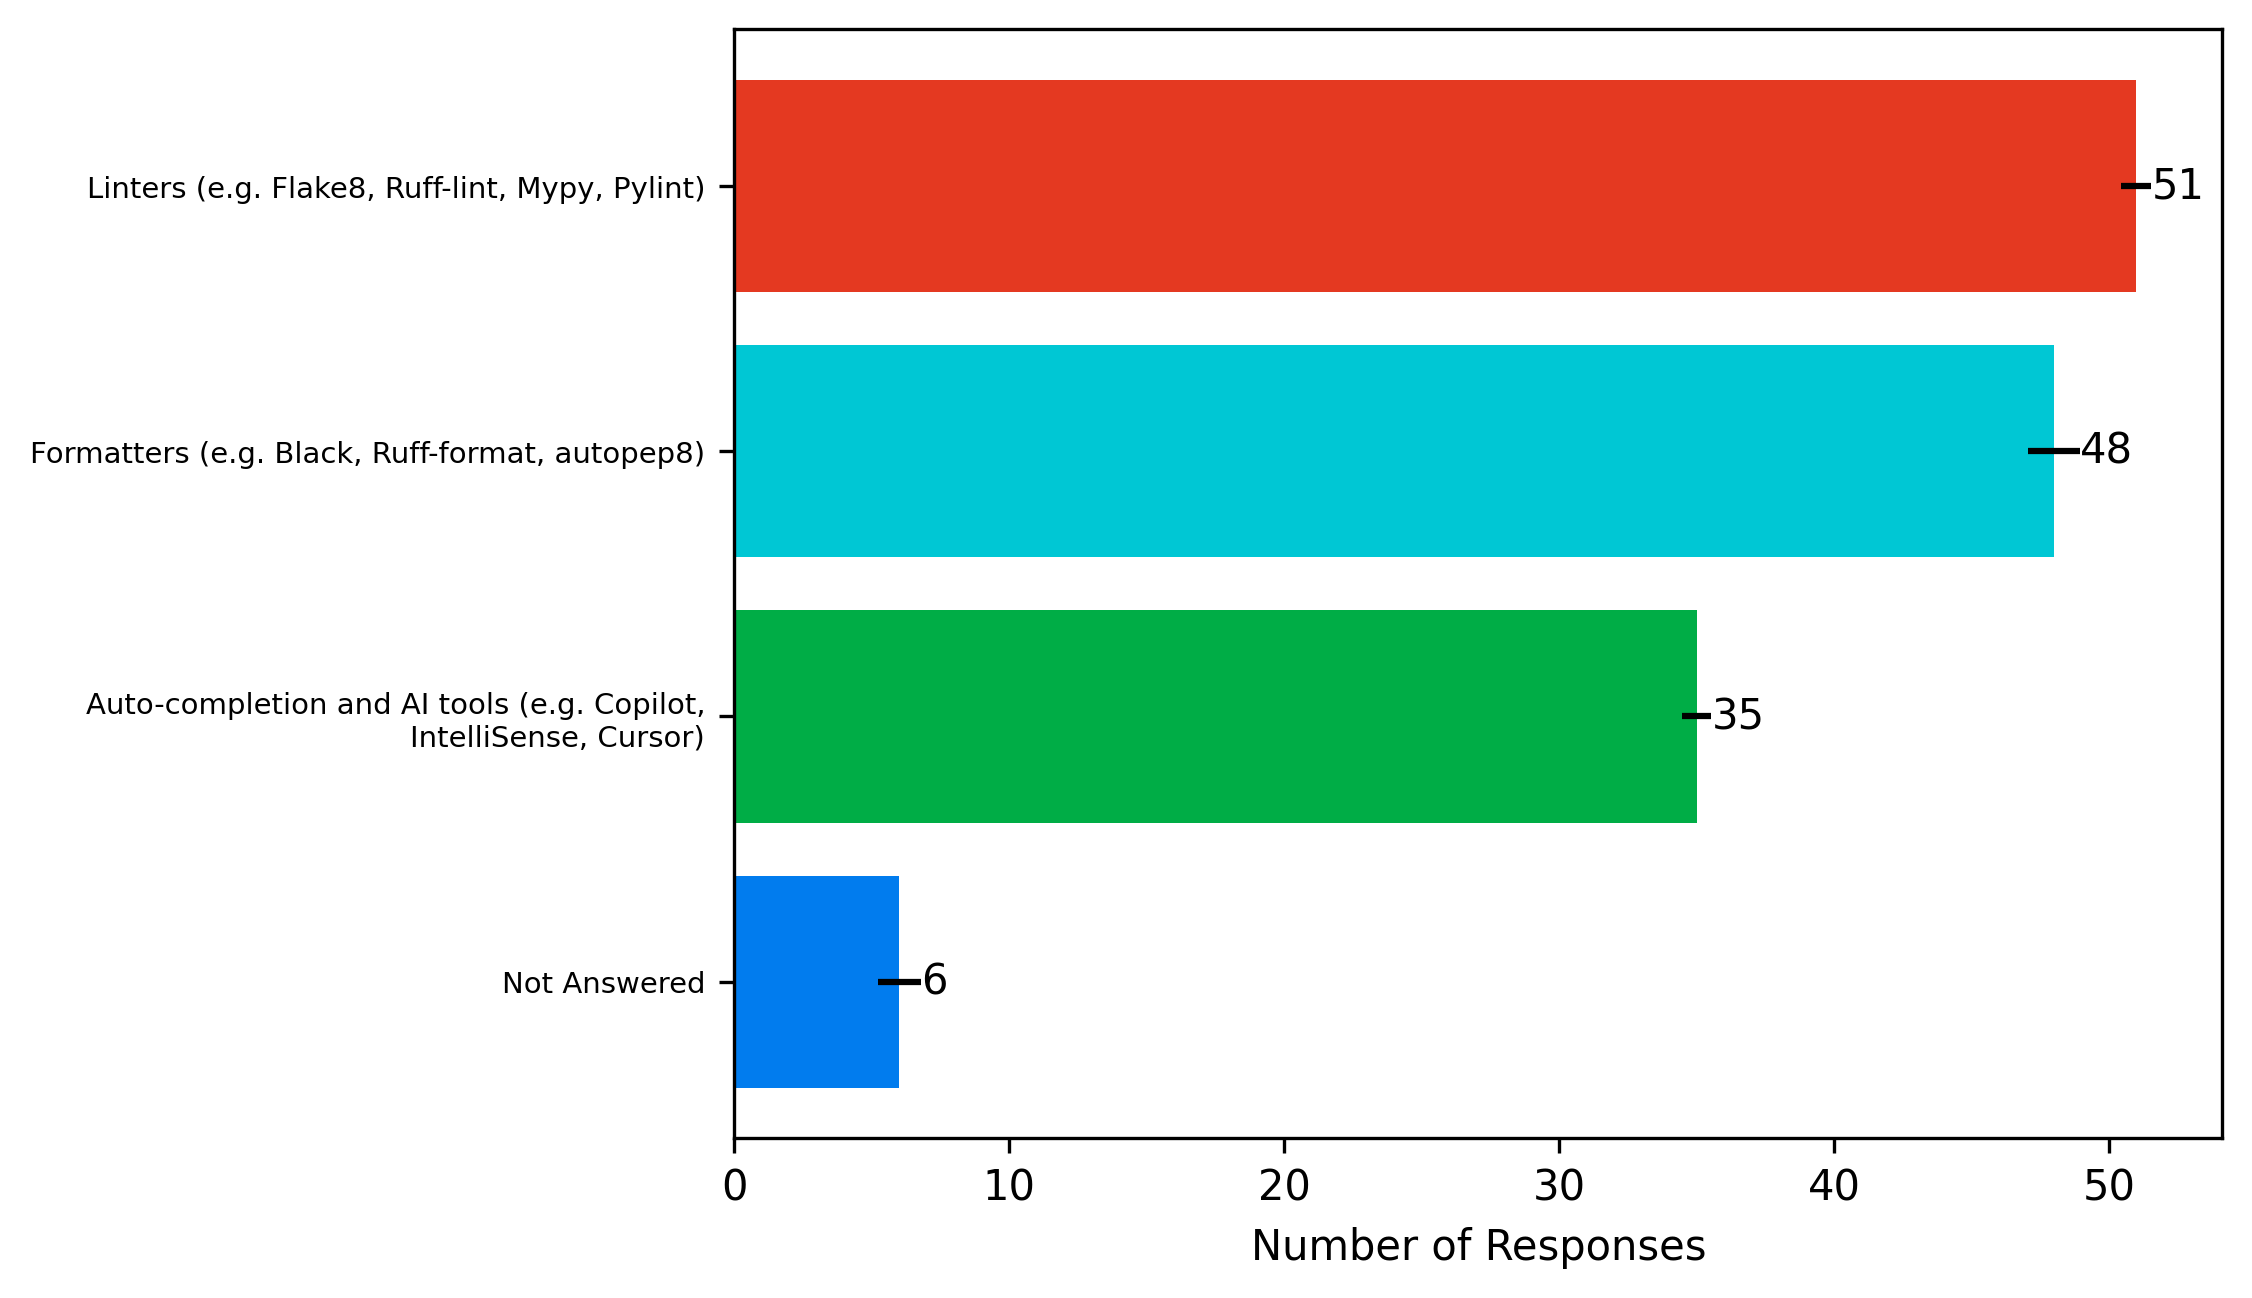

In [21]:
q36_opts = [
    "Linters (e.g. Flake8, Ruff-lint, Mypy, Pylint)",
    "Formatters (e.g. Black, Ruff-format, autopep8)",
    "Auto-completion and AI tools (e.g. Copilot, IntelliSense, Cursor)",
]
q36_res = survey_df["3.6. Which of the following code assistance and inspection tools do you use while developing Airflow DAGs?"].tolist()
plot_checkbox_question_bar(q36_opts, q36_res)

# Q4.1. What is the most time-consuming activity related to developing new DAGs?

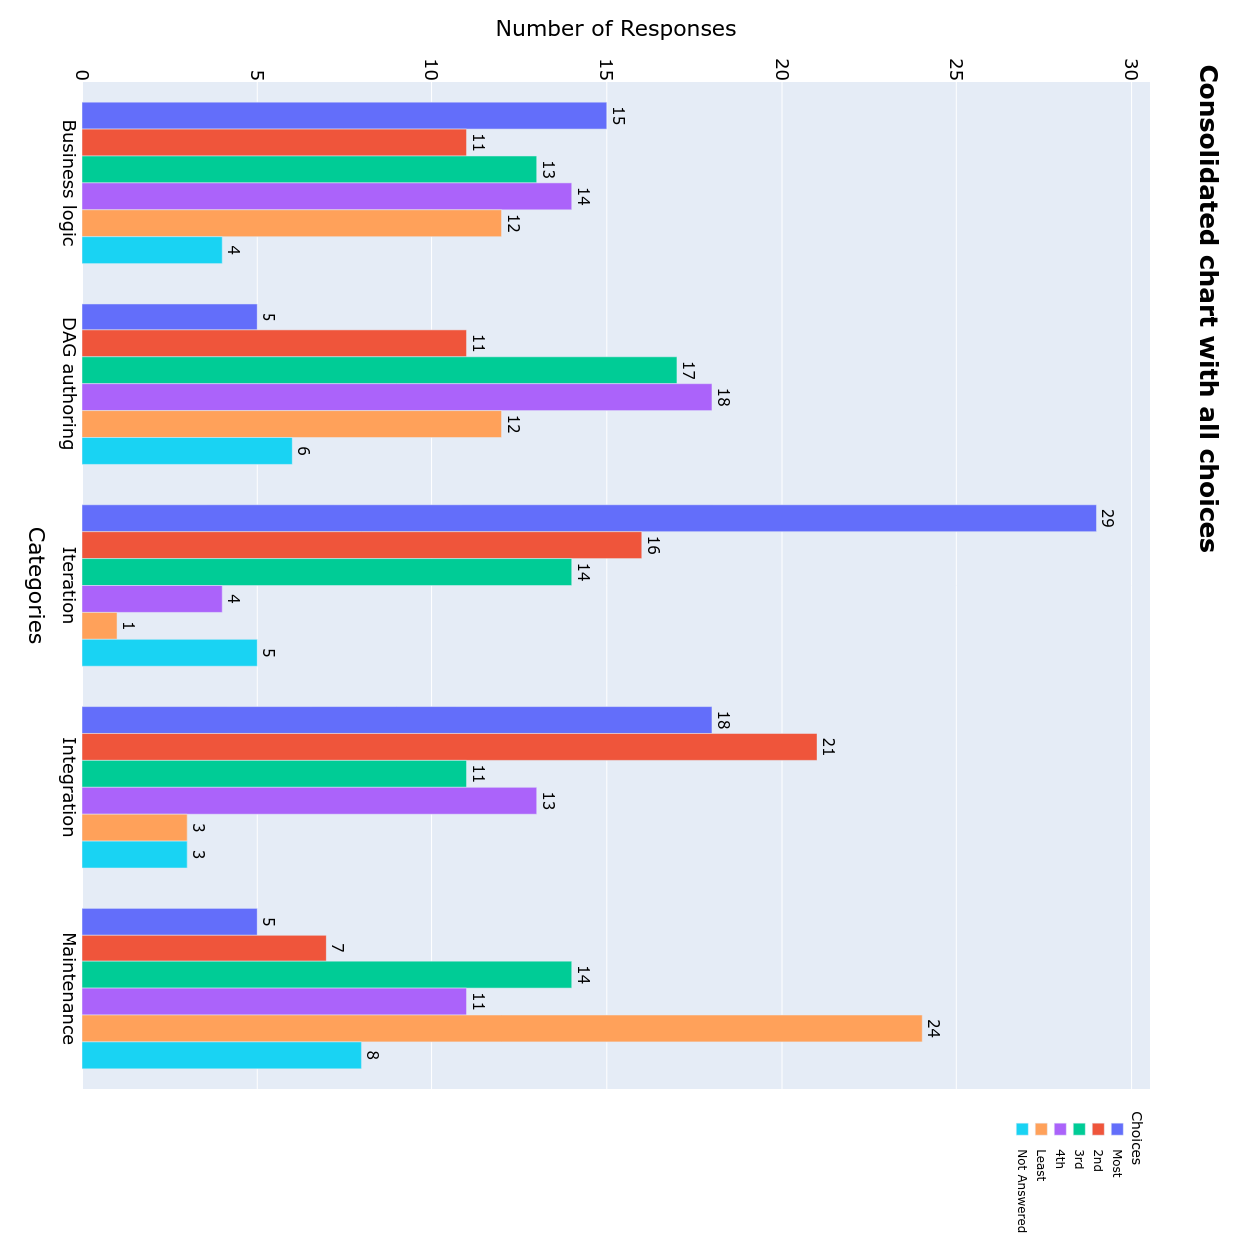

In [22]:
base_question = "4.1. What is the most time-consuming activity related to developing new DAGs?"
q43_opts = ["Most", "2nd", "3rd", "4th", "Least", "Not Answered"]
plot_multichoice_question(survey_df, base_question, q43_opts, num_ranks=5, ranks=[
    "Business logic", "DAG authoring", "Iteration", "Integration", "Maintenance"
])

# Q4.2 What can be improved about the workflow activities mentioned above?

In [23]:
# markdown_print(survey_df, "4.2 What can be improved about the workflow activities mentioned above?")
markdown_raw_print("""
DAG Maintenance:

    Enhancements needed for maintaining DAGs, such as lint warnings for file saving operations without checking folder existence.

Simplified DAG Management:

    Easier processes for uploading new DAGs, clearing specific tasks, rerunning them, and viewing logs with a single IDE command. Immediate DAG parsing when changes occur.

Local Development and Debugging:

    Improvements required for local execution and debugging with IDEs like VS Code.

Documentation:

    Better documentation for integration, explaining different parameters with examples.

DAG Modification in UI:

    Support for temporary DAG modifications in the Airflow UI for debugging and testing.

Log Export:

    Ability to export logs to Kafka.

API Connection Automation:

    Interface to automate connections to API endpoints and load data similarly to tools like Airbyte or River.io.

Handling Variables and Connections:

    Difficulties working with variables and connections during debug sessions due to inconsistent documentation and formats across the Airflow CLI and other tools.

Docker-Compose Performance:

    Docker-compose is slow; finding a better alternative would improve development cycles. Parsing DAGs is particularly challenging.

Testing and Mocking:

    Need for easier mocking, integration testing, and unit testing of Airflow components.

High-Level DAG Navigation:

    Ability to step through the DAG at a high level without complex debugging setups.

Feedback Loop Optimization:

    Anything to speed up the feedback loop is desired.

Connection Parameter Clarity:

    Spending significant time figuring out connection parameters.

DAG Simulation and Testing:

    Easier methods to test or simulate DAG runs or individual task instances.

IDE Plugin:

    An official Airflow plugin for standard editors/IDEs to support autocompletion and documentation viewing.

YAML for Simple DAGs:

    Suggestion to use YAML and forms for creating simple DAGs.

External Resource Handling:

    Improving task relationships with external resources to allow easier testing.

Local Development Support:

    Better support for fully local development workflows, leading to quicker iteration through local DAG execution.

General Feedback Suggestions:

    Built-in support for simulating DAG inputs (e.g., data_interval_start, execution_date).
    Pre-built DAG templates for common patterns to streamline authoring.
    Visual DAG authoring tools for graphical task management to reduce errors and enhance understanding.
""")

### DAG Maintenance:

- Enhancements needed for maintaining DAGs, such as lint warnings for file saving operations without checking folder existence.

### Simplified DAG Management:

- Easier processes for uploading new DAGs, clearing specific tasks, rerunning them, and viewing logs with a single IDE command. Immediate DAG parsing when changes occur.

### Local Development and Debugging:

- Improvements required for local execution and debugging with IDEs like VS Code.

### Documentation:

- Better documentation for integration, explaining different parameters with examples.

### DAG Modification in UI:

- Support for temporary DAG modifications in the Airflow UI for debugging and testing.

### Log Export:

- Ability to export logs to Kafka.

### API Connection Automation:

- Interface to automate connections to API endpoints and load data similarly to tools like Airbyte or River.io.

### Handling Variables and Connections:

- Difficulties working with variables and connections during debug sessions due to inconsistent documentation and formats across the Airflow CLI and other tools.

### Docker-Compose Performance:

- Docker-compose is slow; finding a better alternative would improve development cycles. Parsing DAGs is particularly challenging.

### Testing and Mocking:

- Need for easier mocking, integration testing, and unit testing of Airflow components.

### High-Level DAG Navigation:

- Ability to step through the DAG at a high level without complex debugging setups.

### Feedback Loop Optimization:

- Anything to speed up the feedback loop is desired.

### Connection Parameter Clarity:

- Spending significant time figuring out connection parameters.

### DAG Simulation and Testing:

- Easier methods to test or simulate DAG runs or individual task instances.

### IDE Plugin:

- An official Airflow plugin for standard editors/IDEs to support autocompletion and documentation viewing.

### YAML for Simple DAGs:

- Suggestion to use YAML and forms for creating simple DAGs.

### External Resource Handling:

- Improving task relationships with external resources to allow easier testing.

### Local Development Support:

- Better support for fully local development workflows, leading to quicker iteration through local DAG execution.

### General Feedback Suggestions:

- Built-in support for simulating DAG inputs (e.g., data_interval_start, execution_date).

- Pre-built DAG templates for common patterns to streamline authoring.

- Visual DAG authoring tools for graphical task management to reduce errors and enhance understanding.

# Q4.3. How often do you leave the Airflow UI or CLI (and rely on external tools) to achieve each of the above?

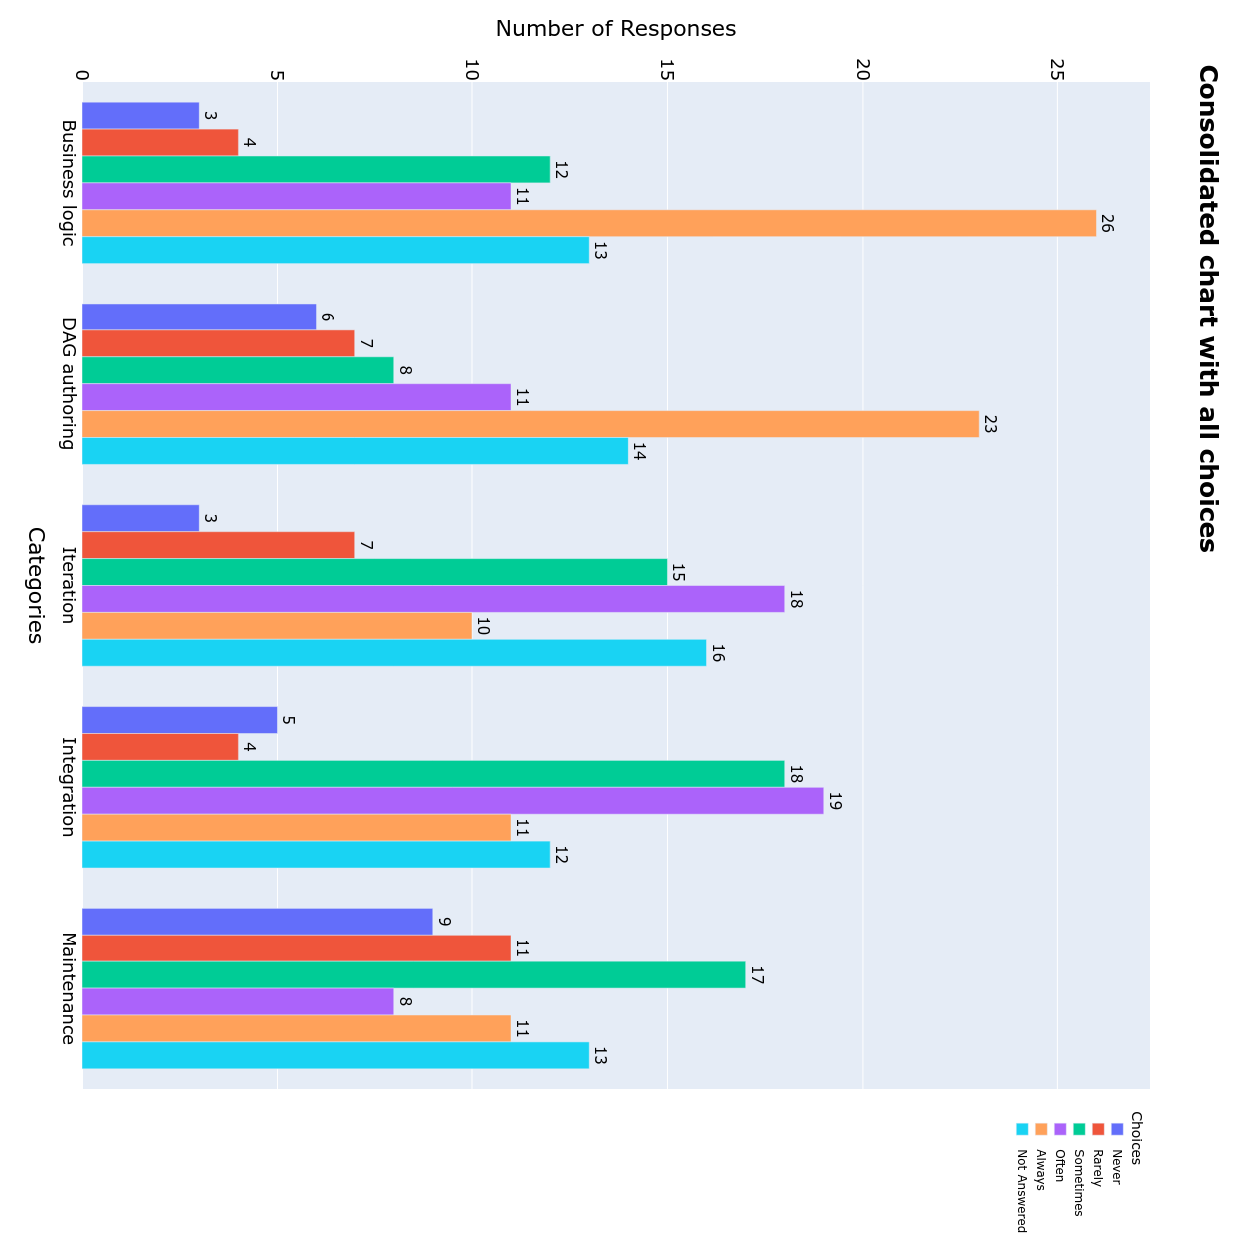

In [24]:
base_question = "4.3. How often do you leave the Airflow UI or CLI (and rely on external tools) to achieve each of the above?"
q43_opts = ["Never", "Rarely", "Sometimes", "Often", "Always", "Not Answered"]
plot_multichoice_question(survey_df, base_question, q43_opts, ranks=[
    "Business logic", "DAG authoring", "Iteration", "Integration", "Maintenance"
])

# Q4.4. Which of the following additions to the Airflow UI could be useful to your debugging efforts?

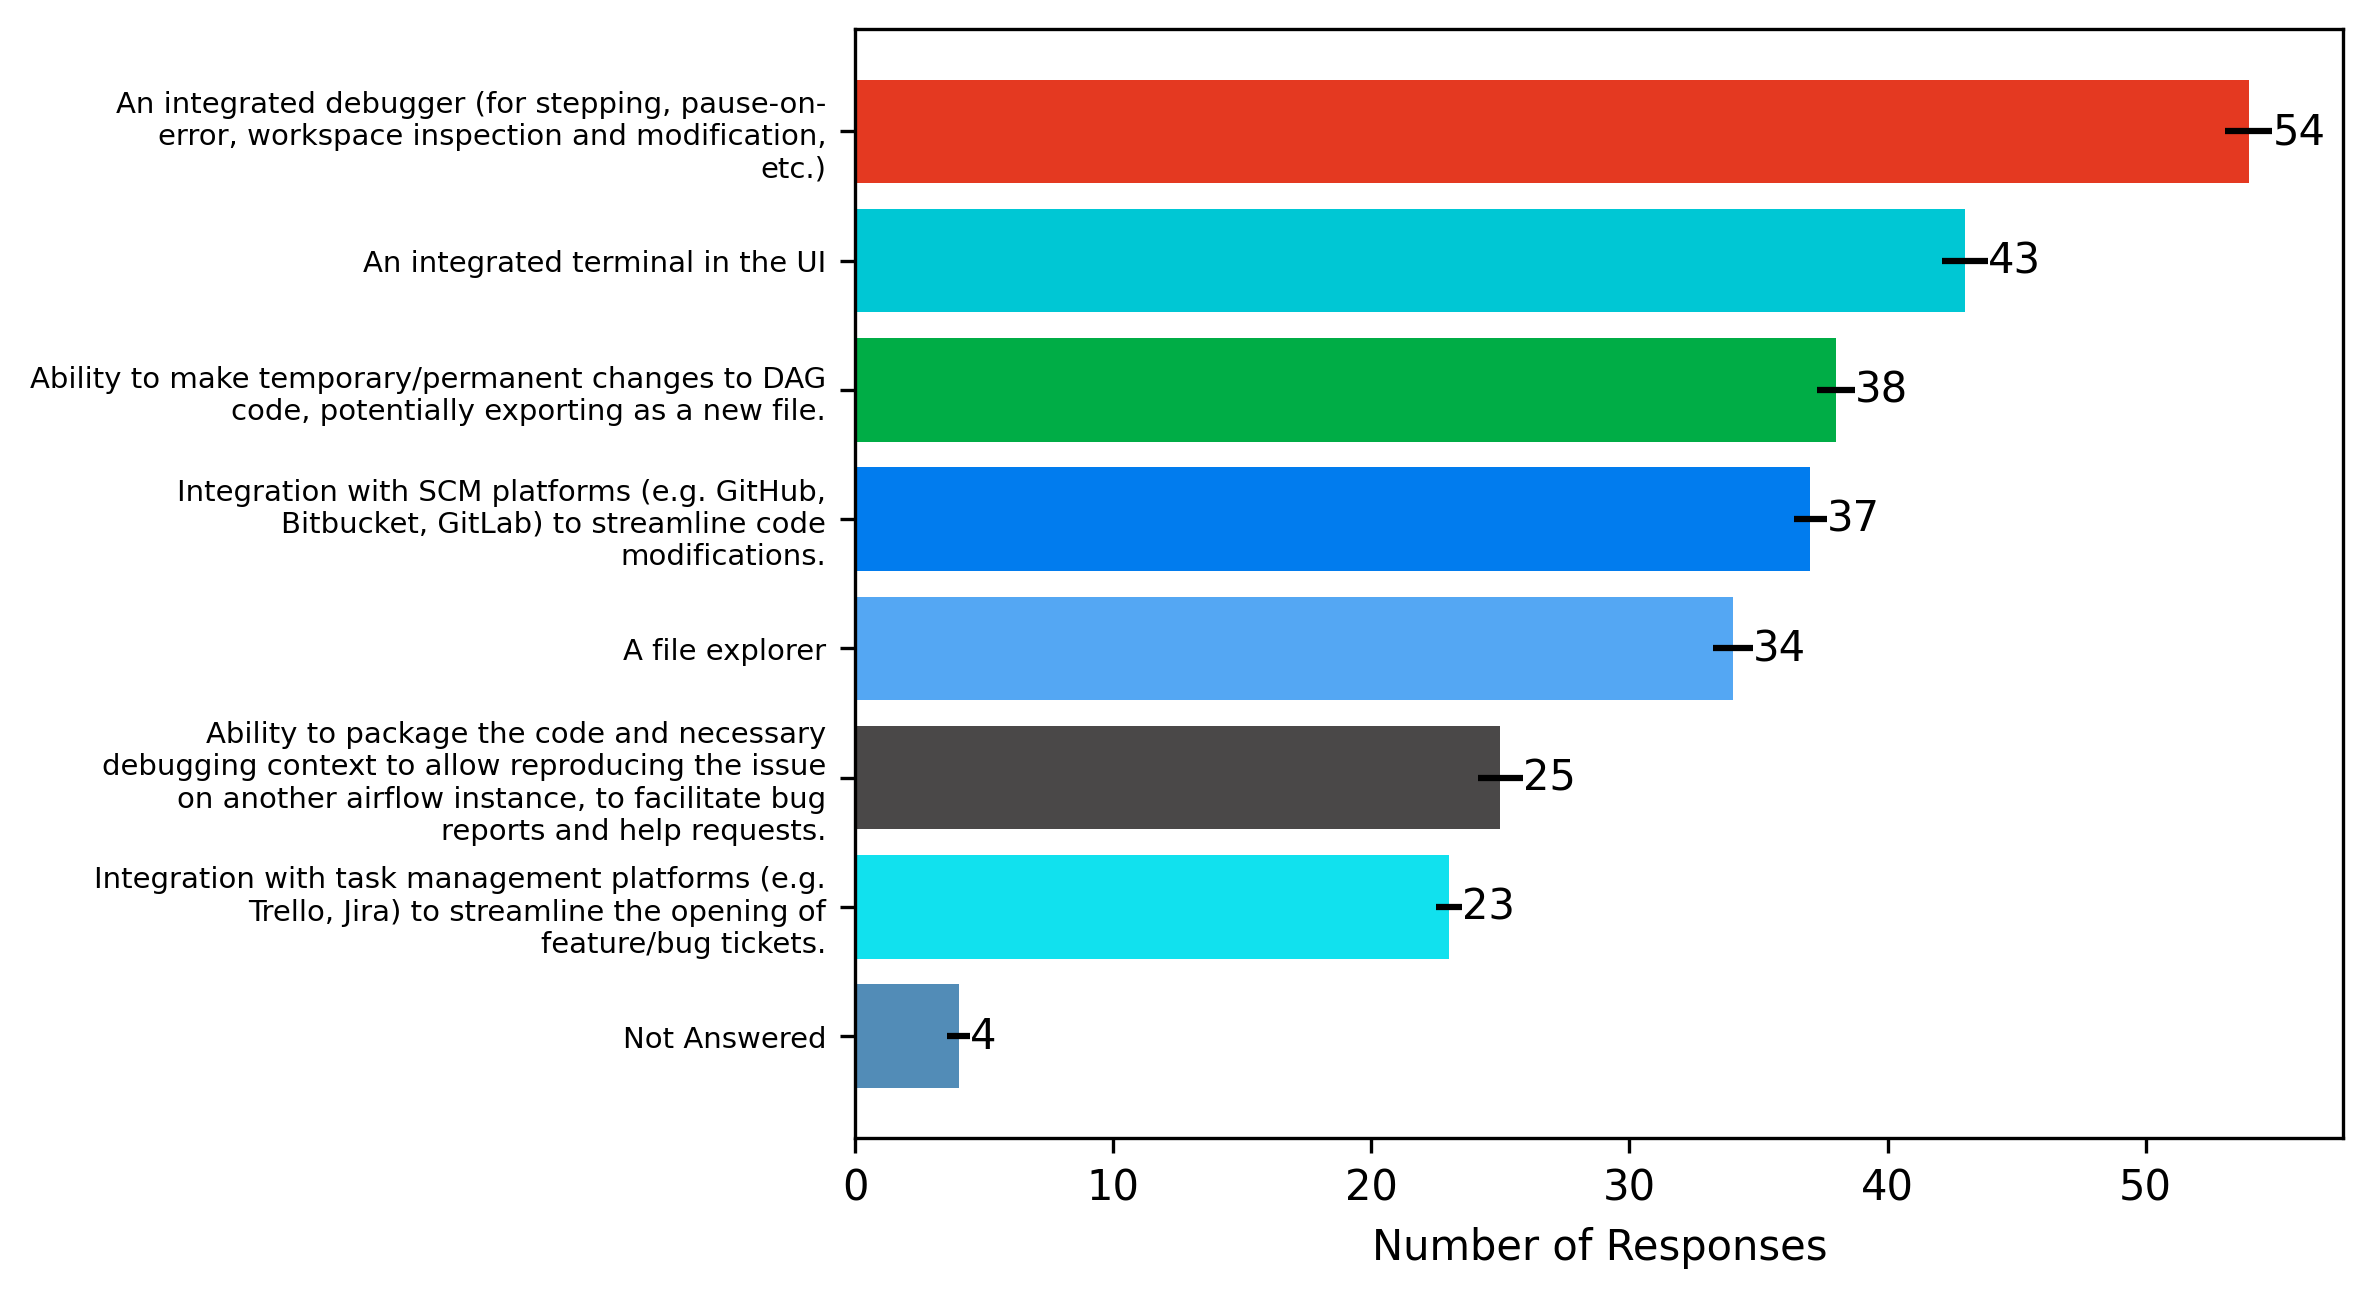

In [25]:
q44_opts = [
    "An integrated terminal in the UI",
    "An integrated debugger (for stepping, pause-on-error, workspace inspection and modification, etc.)",
    "A file explorer",
    "Ability to make temporary/permanent changes to DAG code, potentially exporting as a new file.",
    "Ability to package the code and necessary debugging context to allow reproducing the issue on another airflow instance, to facilitate bug reports and help requests.",
    "Integration with SCM platforms (e.g. GitHub, Bitbucket, GitLab) to streamline code modifications.",
    "Integration with task management platforms (e.g. Trello, Jira) to streamline the opening of feature/bug tickets.",
]
q44_res = survey_df["4.4. Which of the following additions to the Airflow UI could be useful to your debugging efforts?"].tolist()
plot_checkbox_question_bar(q44_opts, q44_res)

# Q4.4.1. Other suggestions:

In [26]:
# markdown_print(survey_df, "4.4.1. Other suggestions:")
markdown_raw_print("""
Local Development and Debugging:

    Easier local execution and integration with IDE debuggers like VS Code.
    Task instance view should allow easy copying of Airflow task test config parameters, as these are often needed in the IDE.

Log Access and Backfilling:

    Provide access to logs for tasks that no longer exist in the DAG interface.
    Implement a UI for backfilling, as CLI access is not available to all users.
    Enhance support for debugging Airflow in Docker using VS Code/Codium.

File Management:

    A file explorer for logs and DAGs with editing capabilities would simplify fixing small bugs.

Web UI Code Editing:

    Desire for a code editor within the web UI.

GitHub Integration:

    Direct integration with GitHub for version control.

DAG Deployment Process:

    Current DAG deployment process is cumbersome, involving uploads to cloud storage and syncing changes in Airflow pods, which can be confusing for developers.
    Clarification needed on whether changes affect task execution (requiring worker pod sync) or DAG execution (requiring scheduler pod sync), leading to lengthy iteration cycles.
    The typical iteration cycle includes uploading, waiting for changes to sync, and then testing, which can be time-consuming.
""")

### Local Development and Debugging:

- Easier local execution and integration with IDE debuggers like VS Code.

- Task instance view should allow easy copying of Airflow task test config parameters, as these are often needed in the IDE.

### Log Access and Backfilling:

- Provide access to logs for tasks that no longer exist in the DAG interface.

- Implement a UI for backfilling, as CLI access is not available to all users.

- Enhance support for debugging Airflow in Docker using VS Code/Codium.

### File Management:

- A file explorer for logs and DAGs with editing capabilities would simplify fixing small bugs.

### Web UI Code Editing:

- Desire for a code editor within the web UI.

### GitHub Integration:

- Direct integration with GitHub for version control.

### DAG Deployment Process:

- Current DAG deployment process is cumbersome, involving uploads to cloud storage and syncing changes in Airflow pods, which can be confusing for developers.

- Clarification needed on whether changes affect task execution (requiring worker pod sync) or DAG execution (requiring scheduler pod sync), leading to lengthy iteration cycles.

- The typical iteration cycle includes uploading, waiting for changes to sync, and then testing, which can be time-consuming.

# Q4.5. What could make DAG.test() more useful?

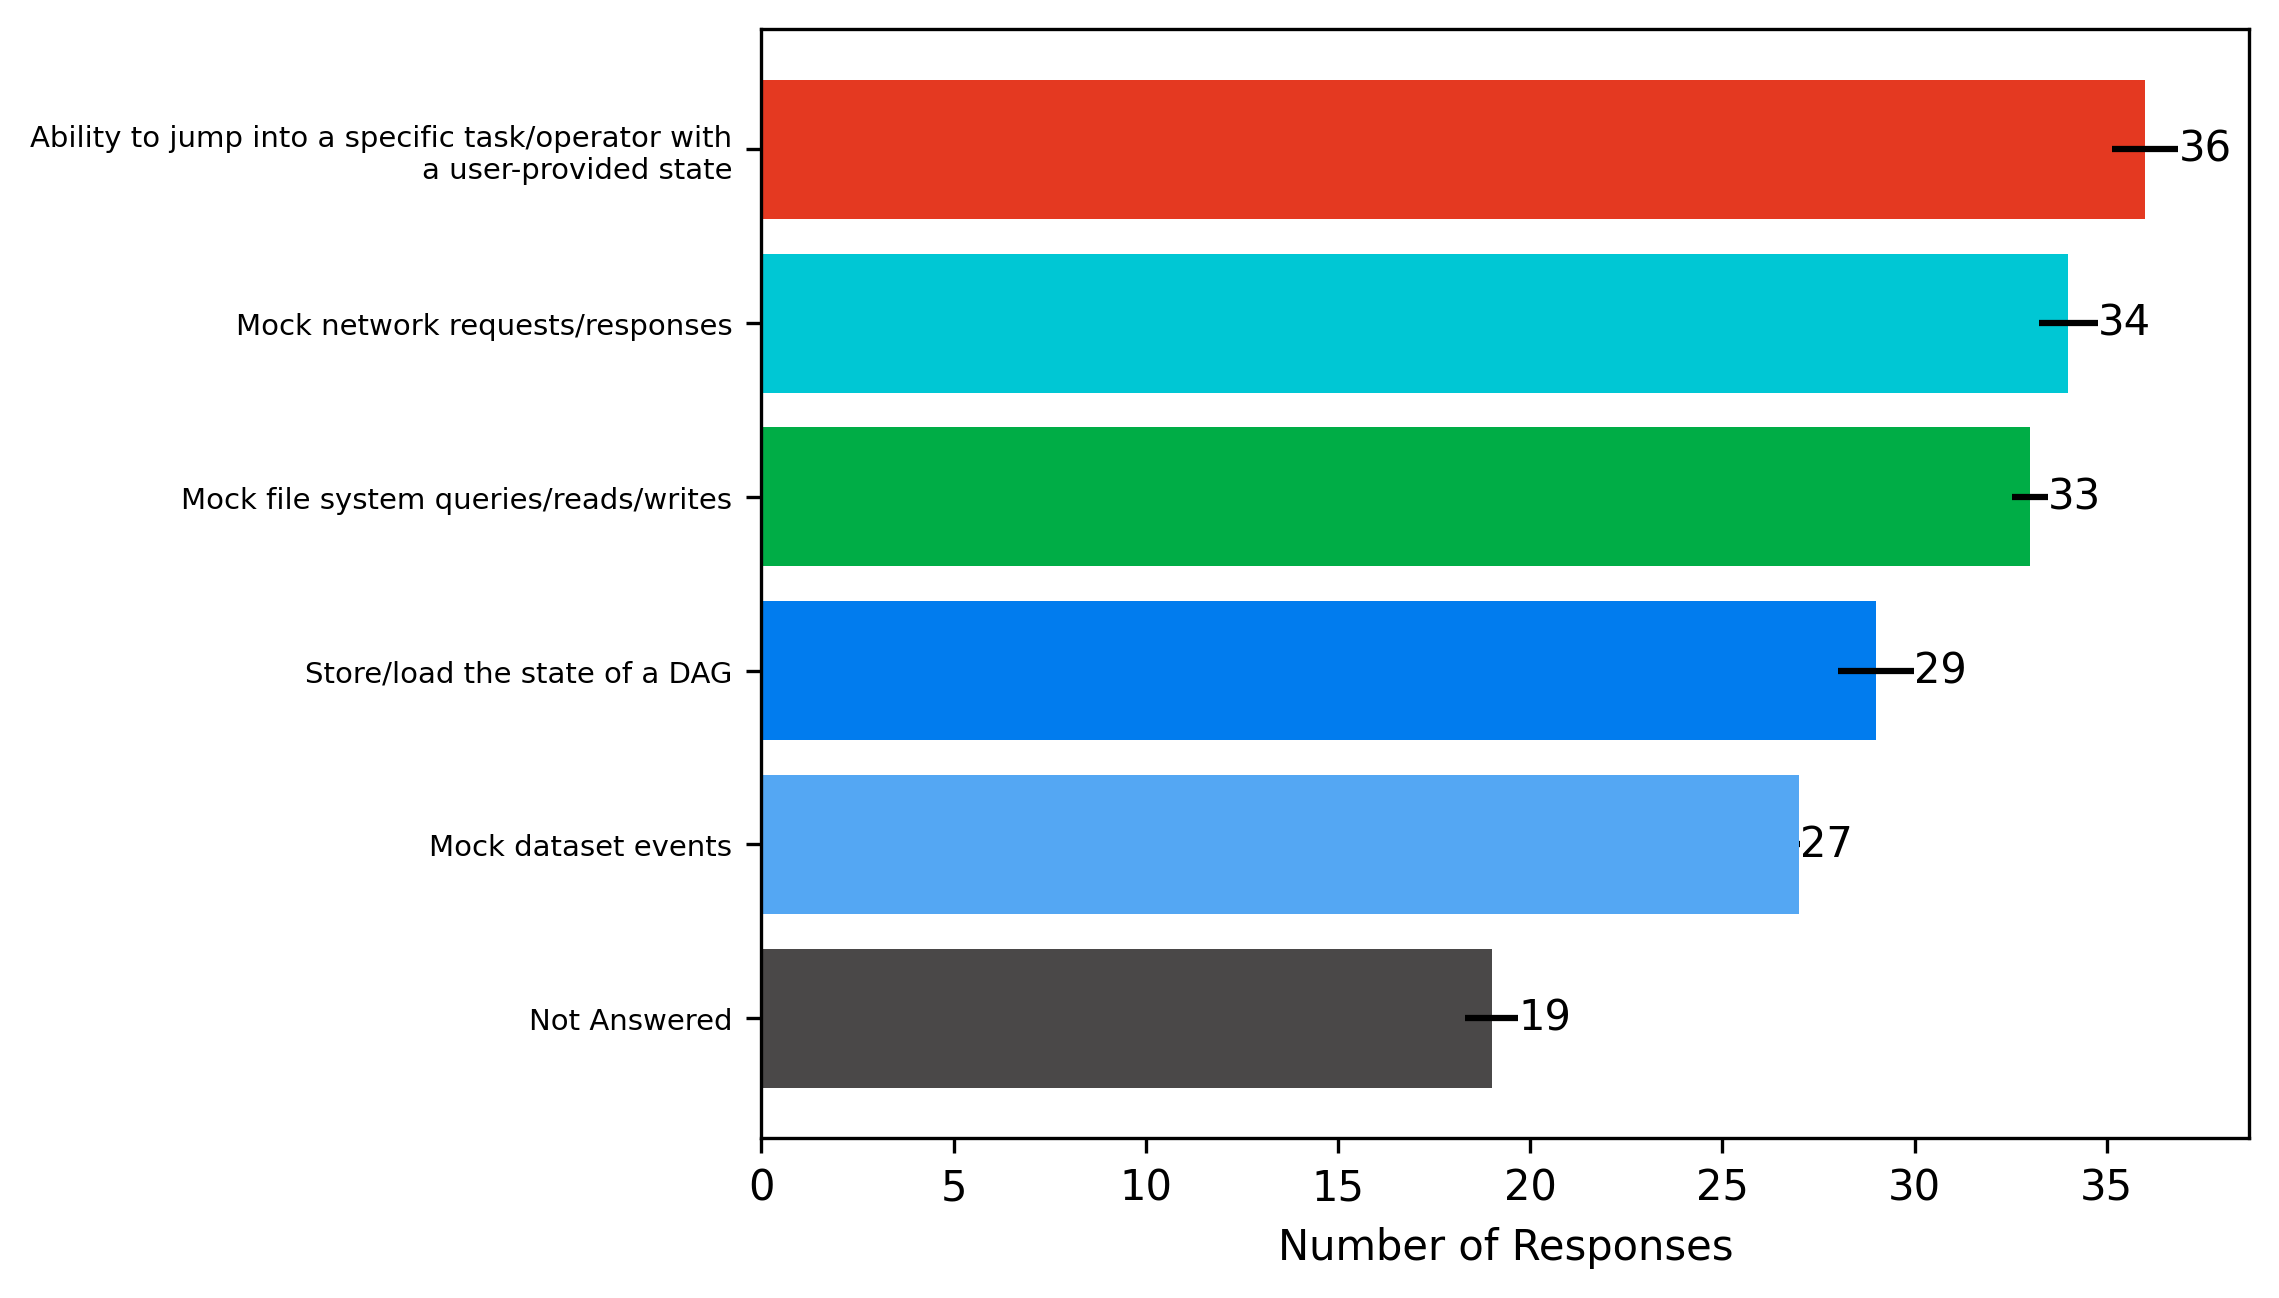

In [27]:
q45_opts = [
    "Mock file system queries/reads/writes",
    "Mock network requests/responses",
    "Mock dataset events",
    "Store/load the state of a DAG",
    "Ability to jump into a specific task/operator with a user-provided state",
]
q45_res = survey_df["4.5. What could make DAG.test() more useful?"].tolist()
plot_checkbox_question_bar(q45_opts, q45_res)

# Q4.5.1. Other suggestions:

In [28]:
# markdown_print(survey_df, "4.5.1. Other suggestions:")
markdown_raw_print("""
Variable Directory Integration:

    Suggestion to integrate with the variables directory.

Mock Cloud Environment:

    Need for a mock cloud environment to simulate service credentials and principals not available locally.

DAG Testing Usage:

    Observations that DAG.test is rarely utilized; preference for launching an Airflow instance for testing.

Task Concurrency:

    Desire for task concurrency support for larger DAGs, emphasizing that this requires a database other than SQLite.
""")

### Variable Directory Integration:

- Suggestion to integrate with the variables directory.

### Mock Cloud Environment:

- Need for a mock cloud environment to simulate service credentials and principals not available locally.

### DAG Testing Usage:

- Observations that DAG.test is rarely utilized; preference for launching an Airflow instance for testing.

### Task Concurrency:

- Desire for task concurrency support for larger DAGs, emphasizing that this requires a database other than SQLite.

# Q4.6. What kind of remote Airflow environment(s) do you use?

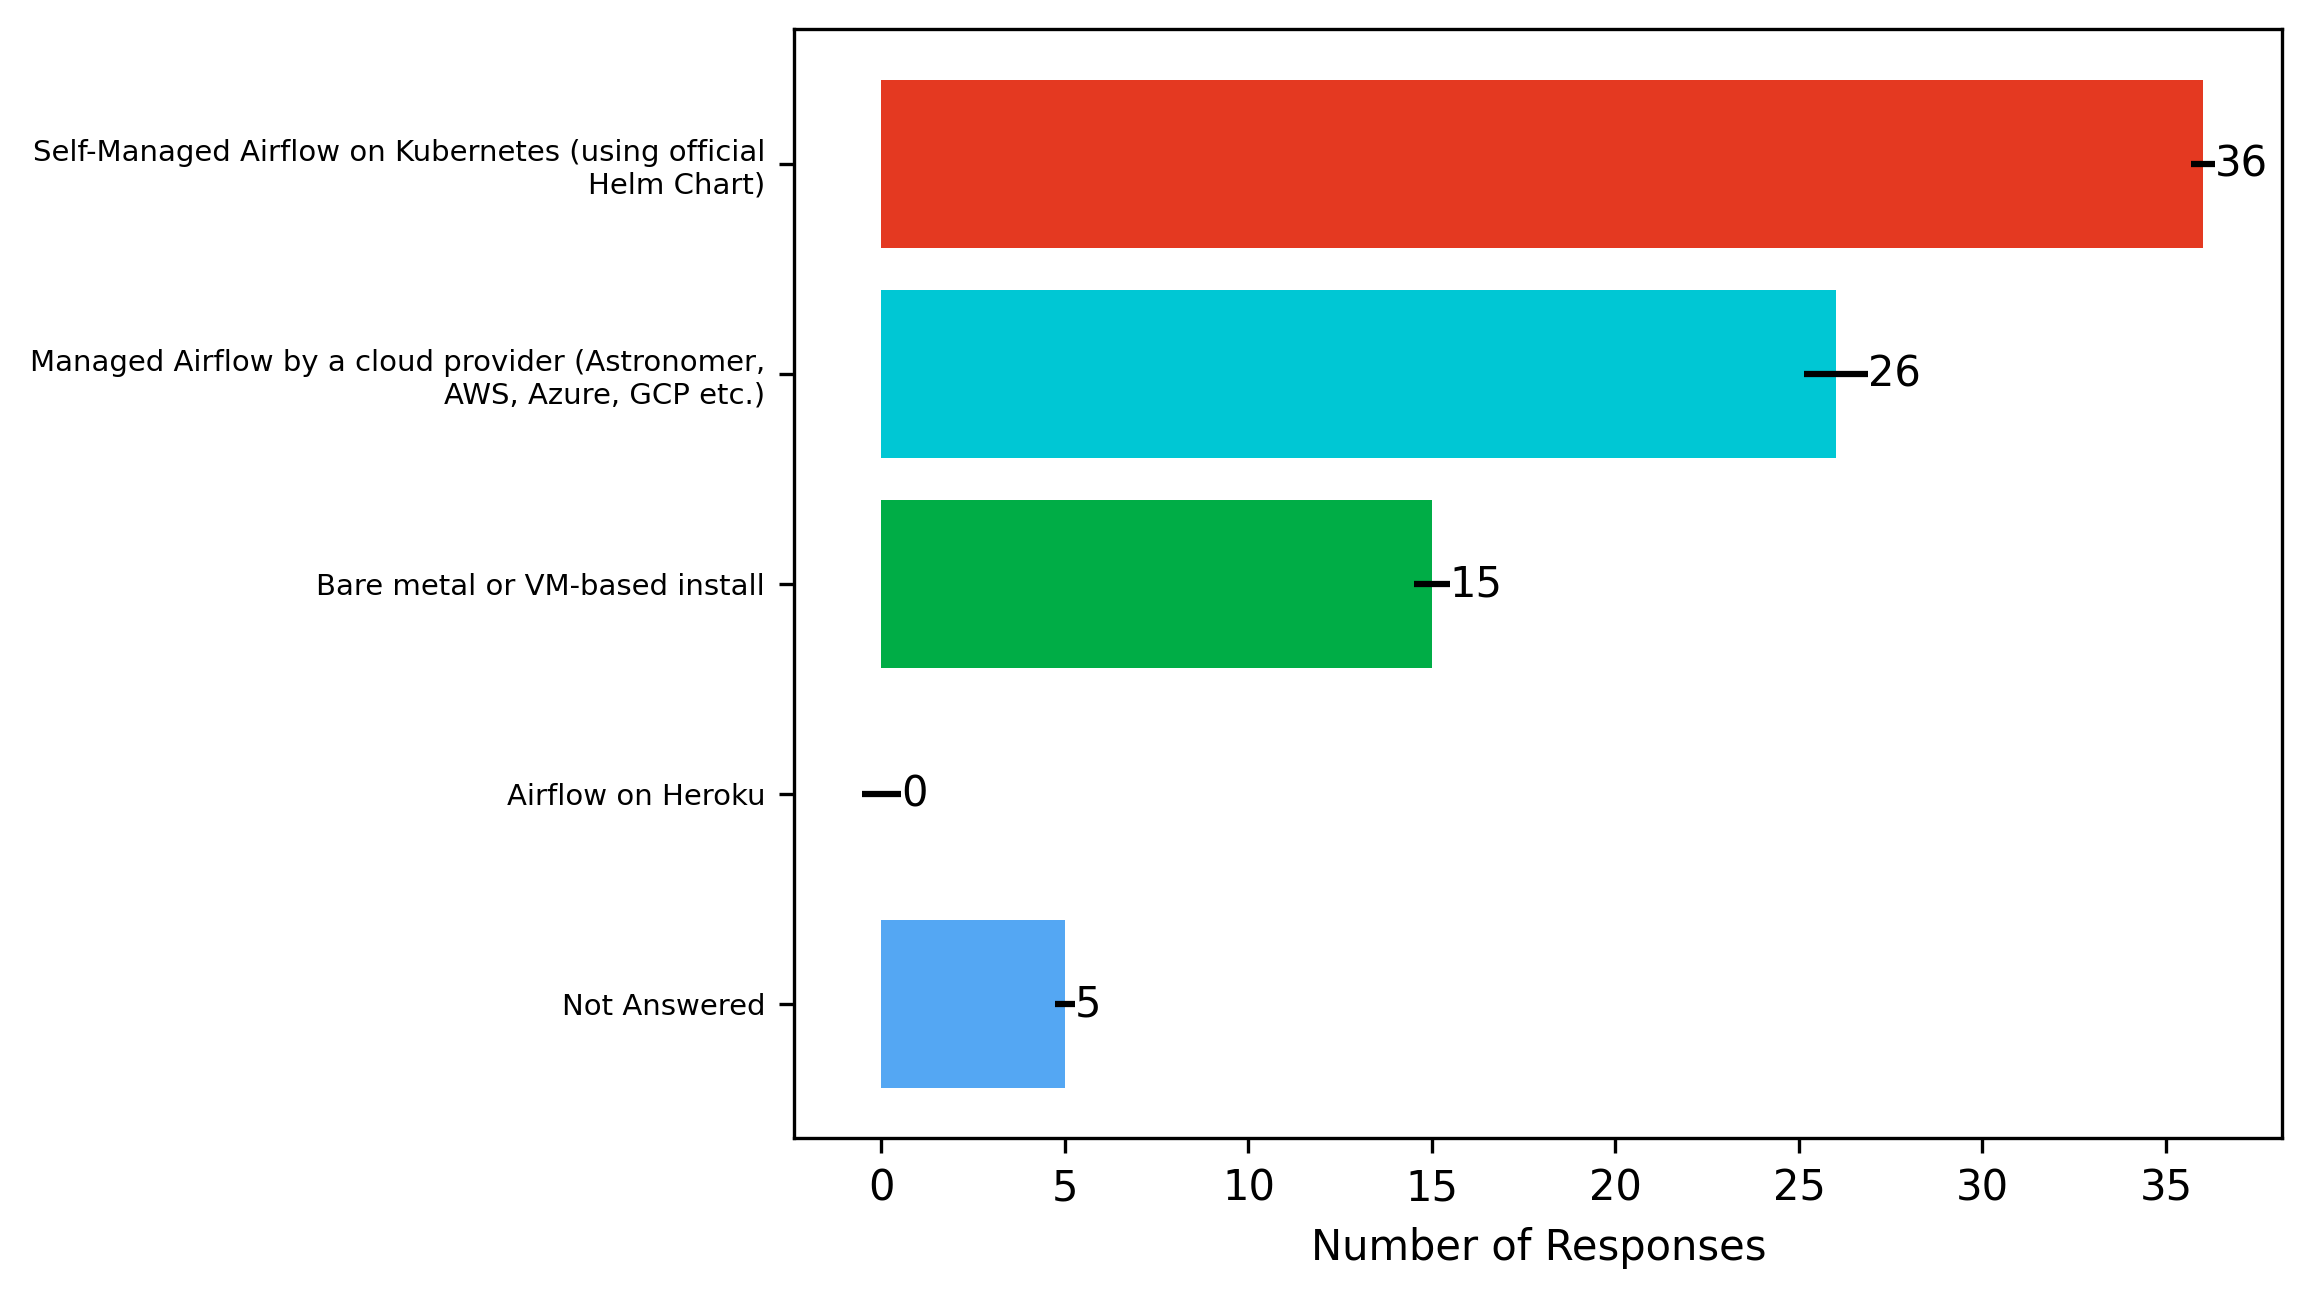

In [29]:
q46_opts = [
    "Self-Managed Airflow on Kubernetes (using official Helm Chart)",
    "Managed Airflow by a cloud provider (Astronomer, AWS, Azure, GCP etc.)",
    "Airflow on Heroku",
    "Bare metal or VM-based install",
]
q46_res = survey_df["4.6. What kind of remote Airflow environment(s) do you use?"].tolist()
plot_checkbox_question_bar(q46_opts, q46_res)

# Q4.7. How would you rate the ease of debugging DAGs in a remote Airflow environment (Kubernetes, Docker, etc.)?

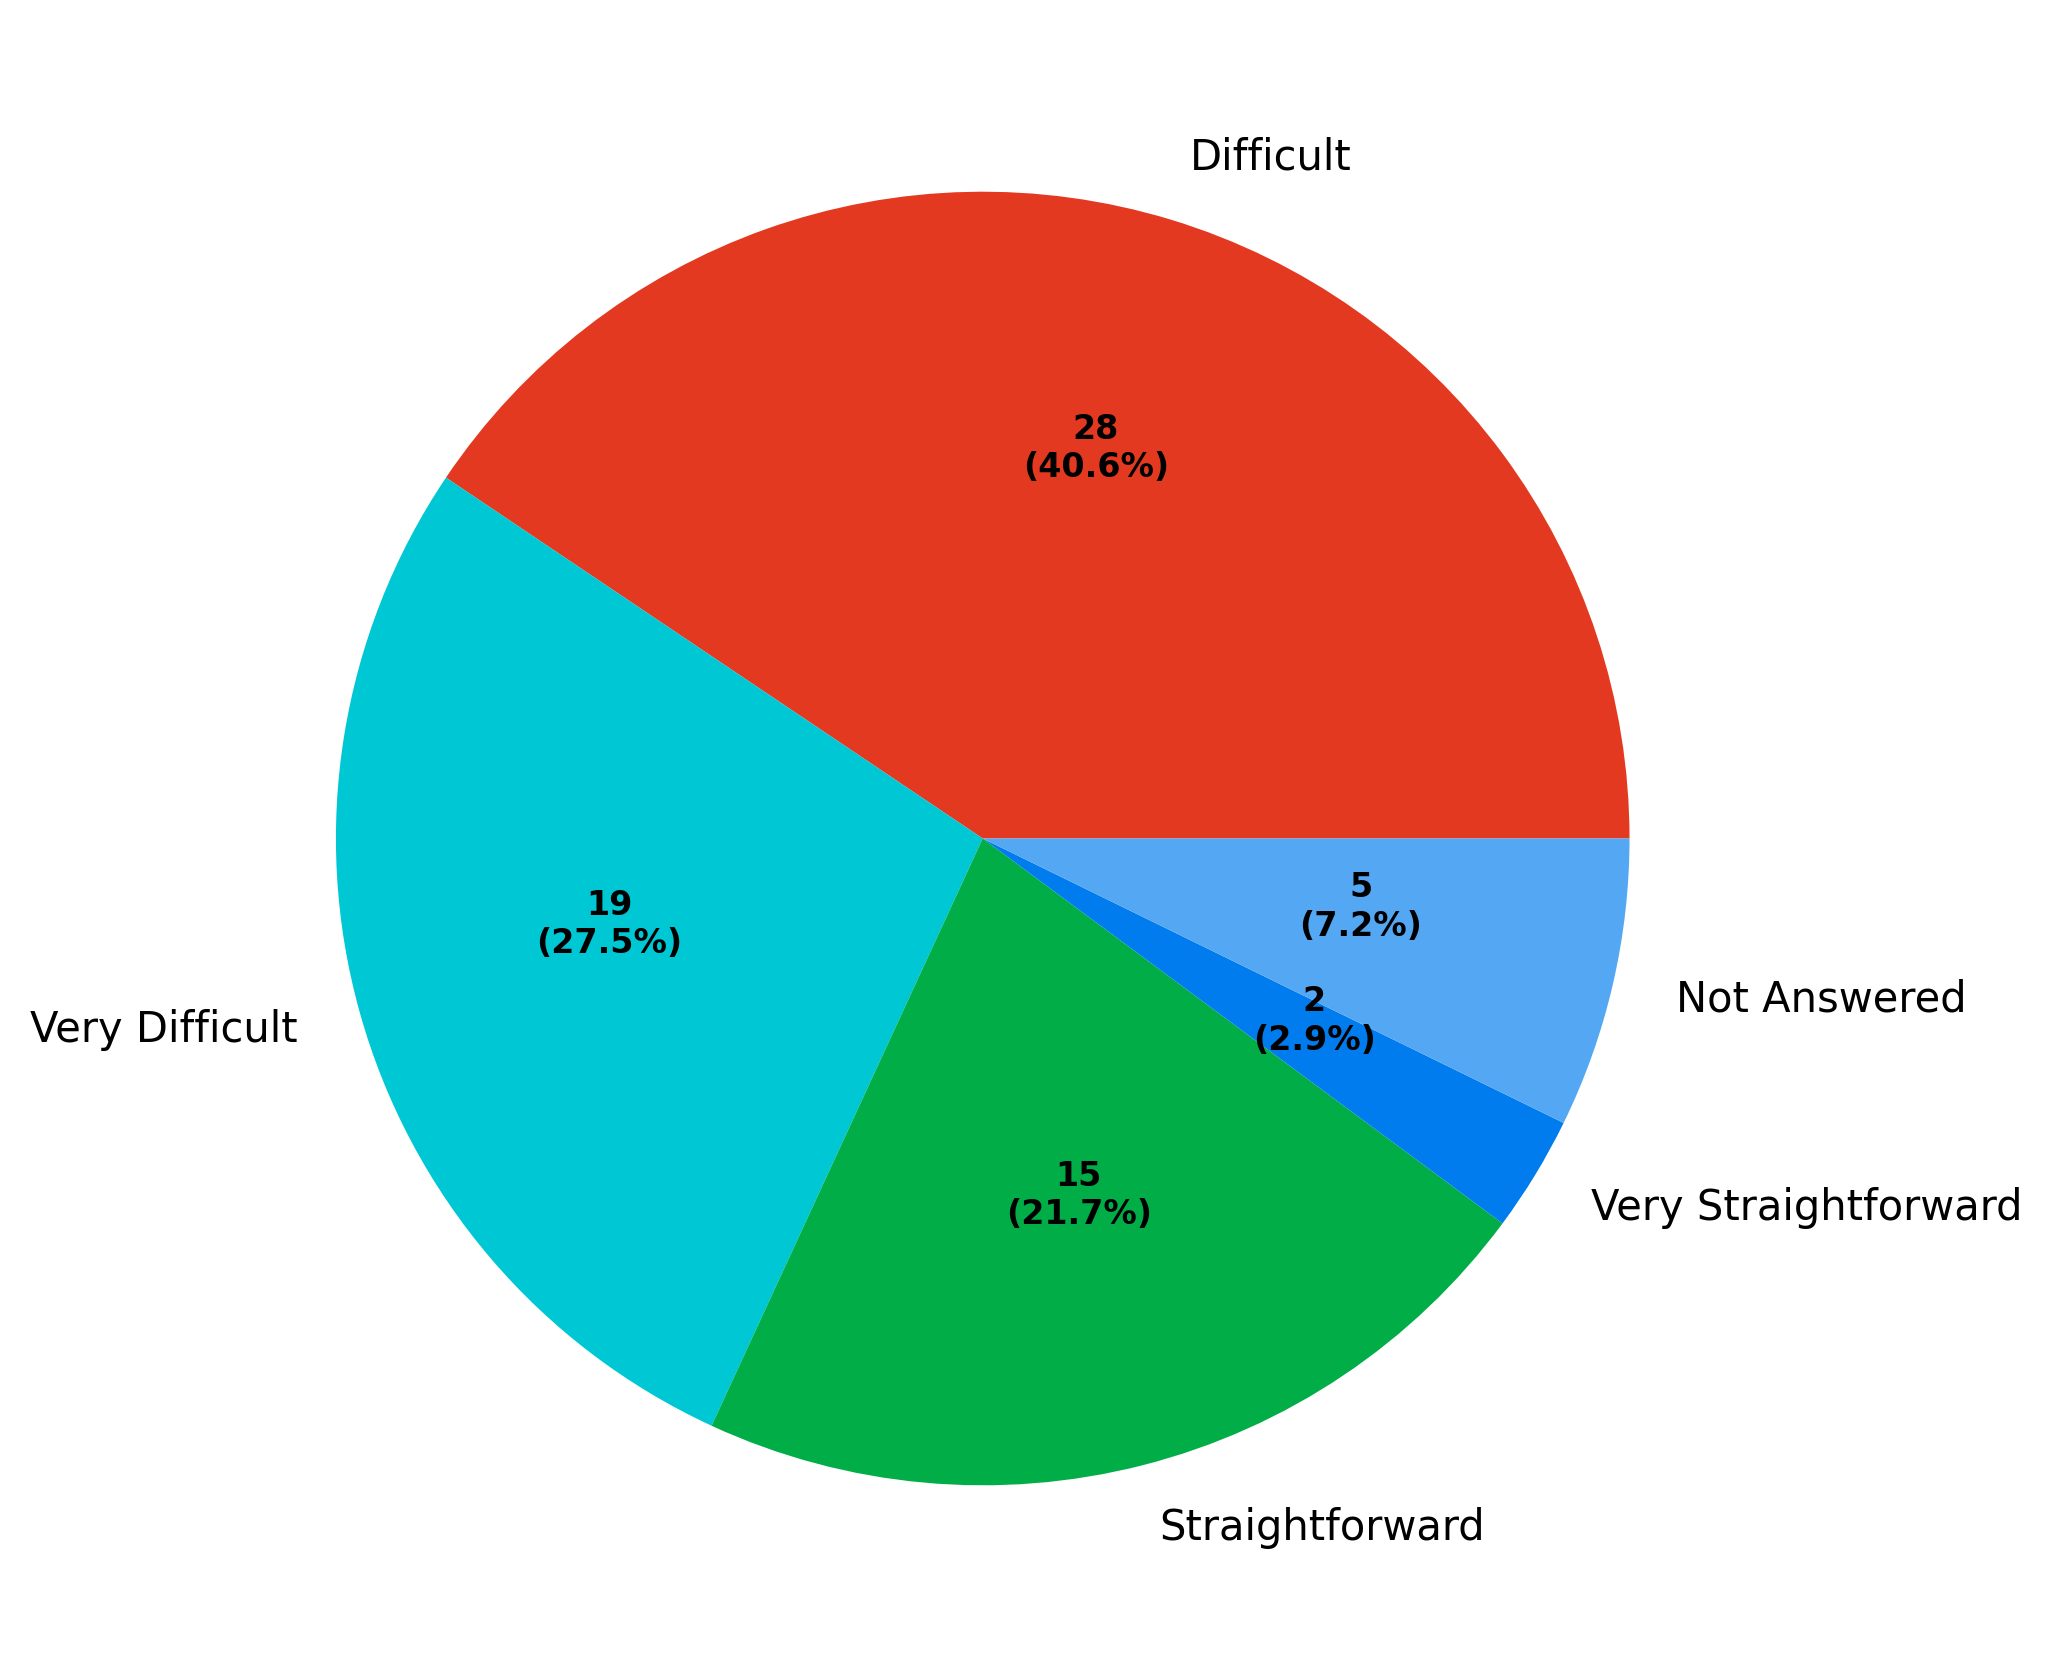

In [30]:
q47_opts = {
    "1": "Very Difficult",
    "2": "Difficult",
    "3": "Straightforward",
    "4": "Very Straightforward",
    "Not Answered": "Not Answered",
}
q47_res = survey_df["4.7. How would you rate the ease of debugging DAGs in a remote Airflow environment (Kubernetes, Docker, etc.)?"].tolist()
plot_checkbox_question_pie(q47_opts, q47_res)

# Q4.7.1. What can make debugging a remote Airflow deployment easier or more efficient?

In [31]:
# markdown_print(survey_df, "4.7.1. What can make debugging a remote Airflow deployment easier or more efficient?")
markdown_raw_print("""
Debugger Integration:

    Improved documentation on attaching debuggers to DAG runs, with step-by-step instructions for VS Code and PyCharm.
    Option to delay execution until a debugger is attached.

APIs for IDE Extensions:

    APIs to allow IDEs to upload DAGs, force re-parsing, set debug breakpoints, stream logs, and fetch remote debugger endpoints for VS Code.

Data Export:

    Ability to export statistics to CSV for easier analysis of DAG runs and task instances.

VS Code/Codium Support:

    Enhanced support for VS Code/Codium, including an integrated console for inspecting environment variables and the file system.

Monitoring and Logging:

    Better monitoring of resource consumption with clearer error messages.
    Built-in debugger with breakpoint functionality.

Remote Access Limitations:

    Acknowledgment that some providers disallow remote debugging and shell access, highlighting the potential utility of an integrated terminal/file browser.

Documentation and Awareness:

    Need for clearer documentation regarding capabilities, especially in environments without CLI access (e.g., MWAA).

Feedback Loop Improvements:

    Features to speed up development, like running individual tasks instead of entire DAGs, per-DAG log level settings, and terminal sessions for debugging through the Airflow UI.

Kubernetes-Specific Feedback:

    Request for pod-wise diagnostics in the Cluster Activity page for easier monitoring without using kubectl.

Task Instance Breakpoints:

    Ability to set breakpoints when executing task instances.

DevContainers:

    Inquiry about the use of DevContainers.

Airflow UI Editor:

    Providing an editor in the Airflow UI that reflects changes and commits to the respective repository.

XCom Integration:

    Improving XComs to better integrate with external resources, allowing easy access to data from locations like Snowflake or S3.

DAG Parsing Speed:

    Faster DAG parsing with real-time updates upon changes.
""")

### Debugger Integration:

- Improved documentation on attaching debuggers to DAG runs, with step-by-step instructions for VS Code and PyCharm.

- Option to delay execution until a debugger is attached.

### APIs for IDE Extensions:

- APIs to allow IDEs to upload DAGs, force re-parsing, set debug breakpoints, stream logs, and fetch remote debugger endpoints for VS Code.

### Data Export:

- Ability to export statistics to CSV for easier analysis of DAG runs and task instances.

### VS Code/Codium Support:

- Enhanced support for VS Code/Codium, including an integrated console for inspecting environment variables and the file system.

### Monitoring and Logging:

- Better monitoring of resource consumption with clearer error messages.

- Built-in debugger with breakpoint functionality.

### Remote Access Limitations:

- Acknowledgment that some providers disallow remote debugging and shell access, highlighting the potential utility of an integrated terminal/file browser.

### Documentation and Awareness:

- Need for clearer documentation regarding capabilities, especially in environments without CLI access (e.g., MWAA).

### Feedback Loop Improvements:

- Features to speed up development, like running individual tasks instead of entire DAGs, per-DAG log level settings, and terminal sessions for debugging through the Airflow UI.

### Kubernetes-Specific Feedback:

- Request for pod-wise diagnostics in the Cluster Activity page for easier monitoring without using kubectl.

### Task Instance Breakpoints:

- Ability to set breakpoints when executing task instances.

### DevContainers:

- Inquiry about the use of DevContainers.

### Airflow UI Editor:

- Providing an editor in the Airflow UI that reflects changes and commits to the respective repository.

### XCom Integration:

- Improving XComs to better integrate with external resources, allowing easy access to data from locations like Snowflake or S3.

### DAG Parsing Speed:

- Faster DAG parsing with real-time updates upon changes.

# Q5.1. How would you describe your proficiency level with Airflow?

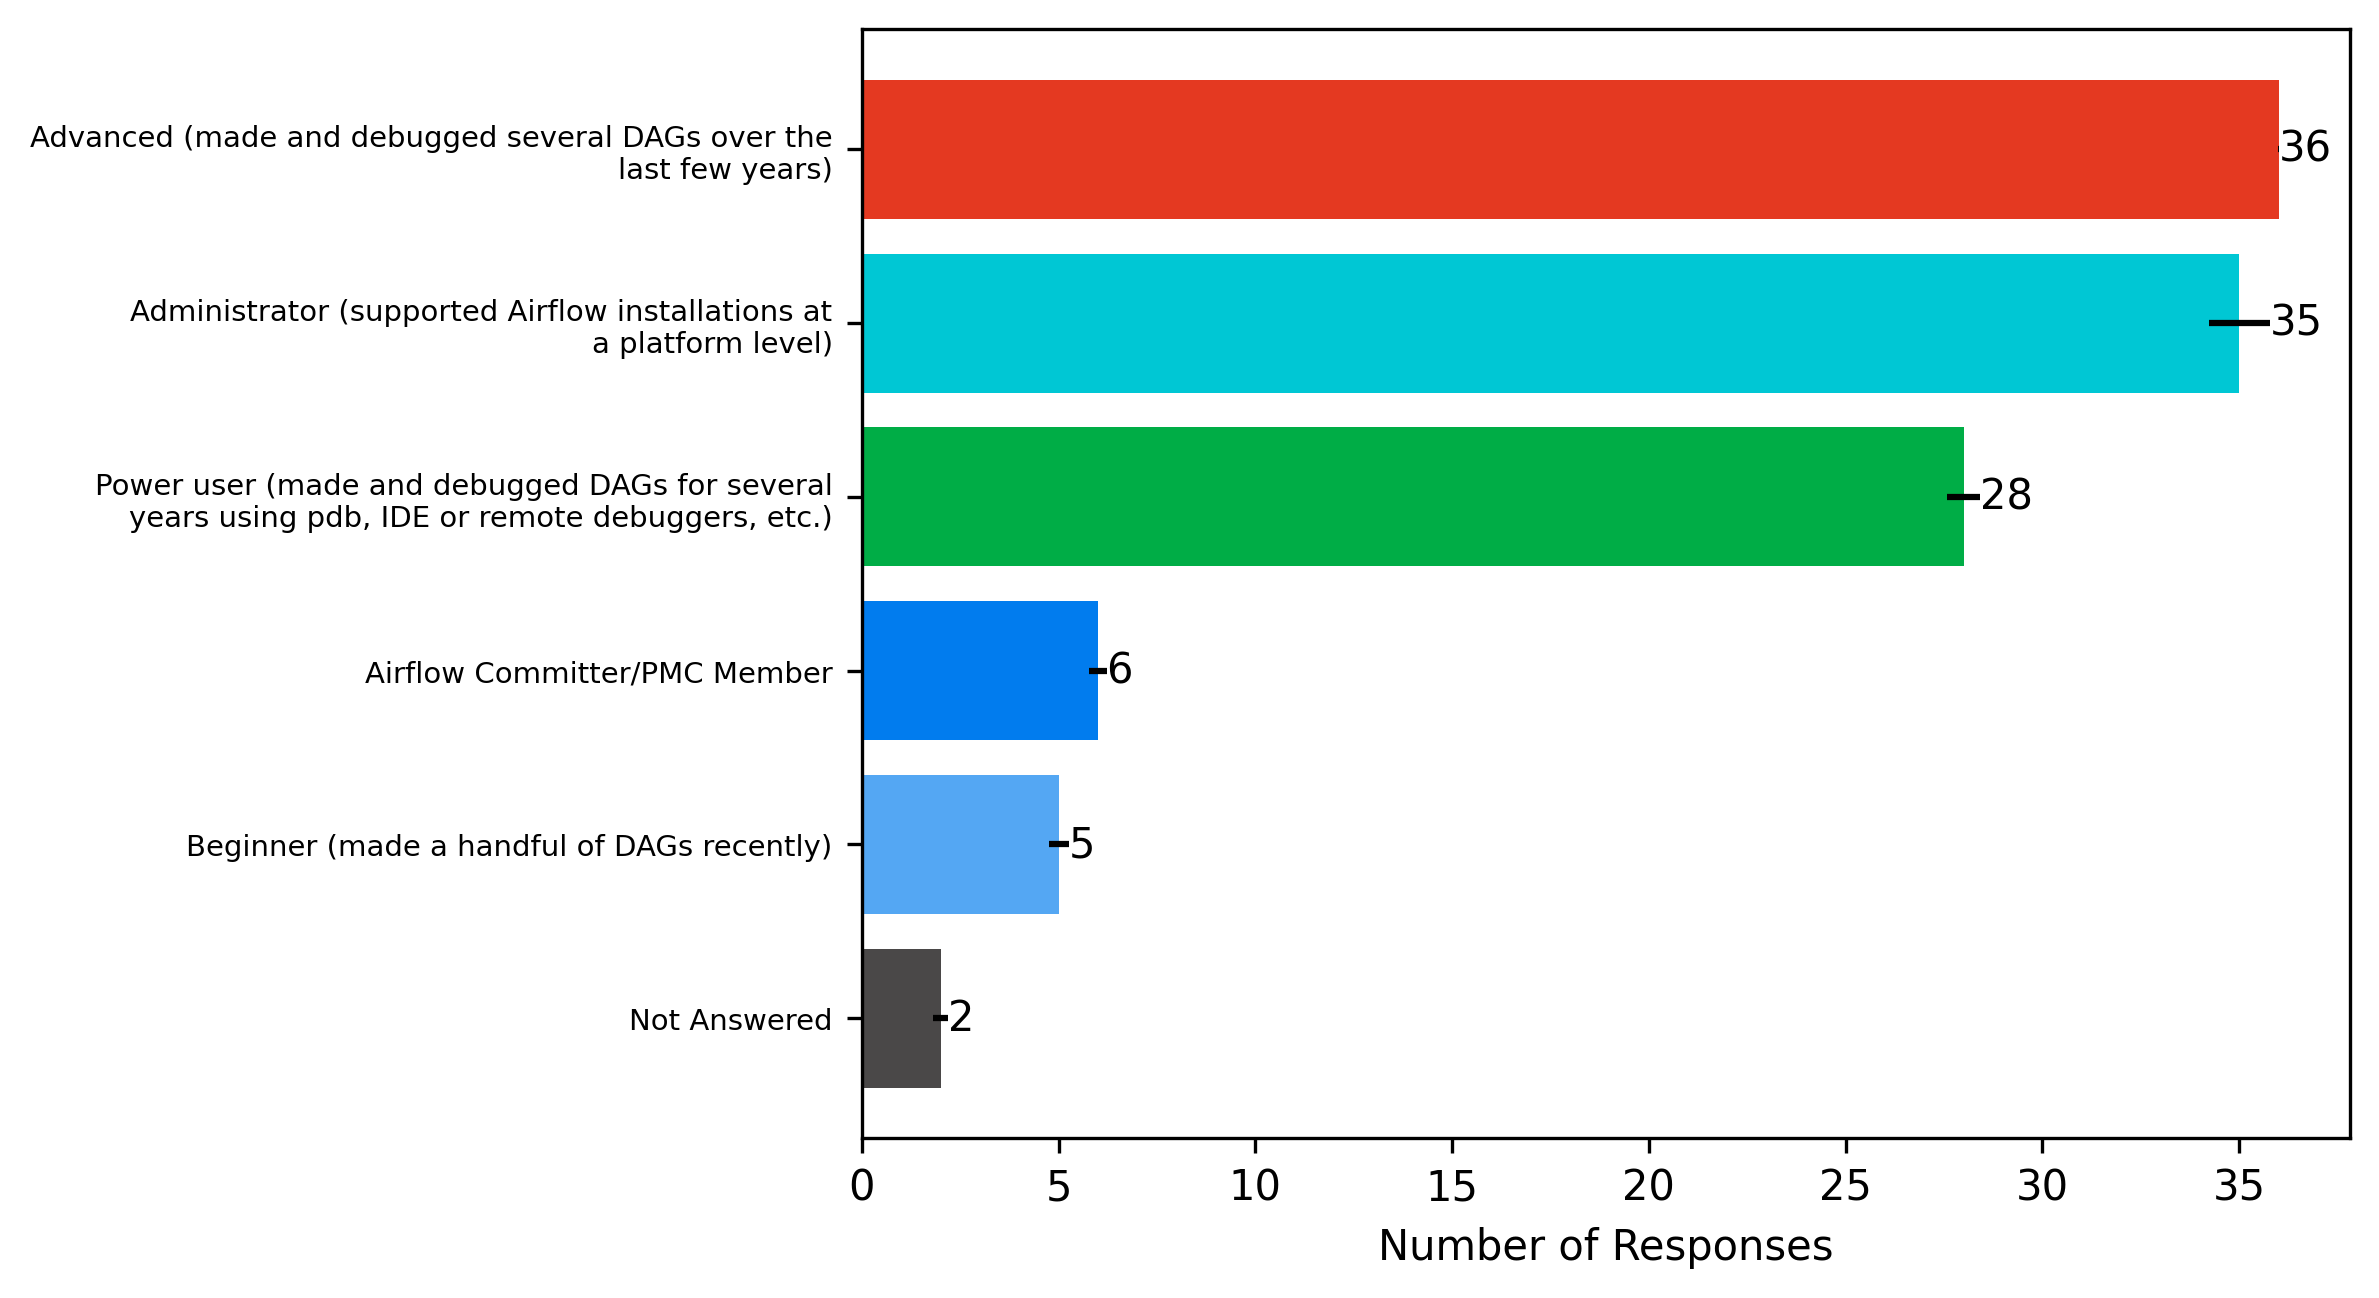

In [32]:
q51_opts = [
    "Beginner (made a handful of DAGs recently)",
    "Advanced (made and debugged several DAGs over the last few years)",
    "Power user (made and debugged DAGs for several years using pdb, IDE or remote debuggers, etc.)",
    "Administrator (supported Airflow installations at a platform level)",
    "Airflow Committer/PMC Member",
]
q51_res = survey_df["5.1. How would you describe your proficiency level with Airflow?"].tolist()
plot_checkbox_question_bar(q51_opts, q51_res)

# Q5.2. What are your responsibilities in the context of using Airflow?

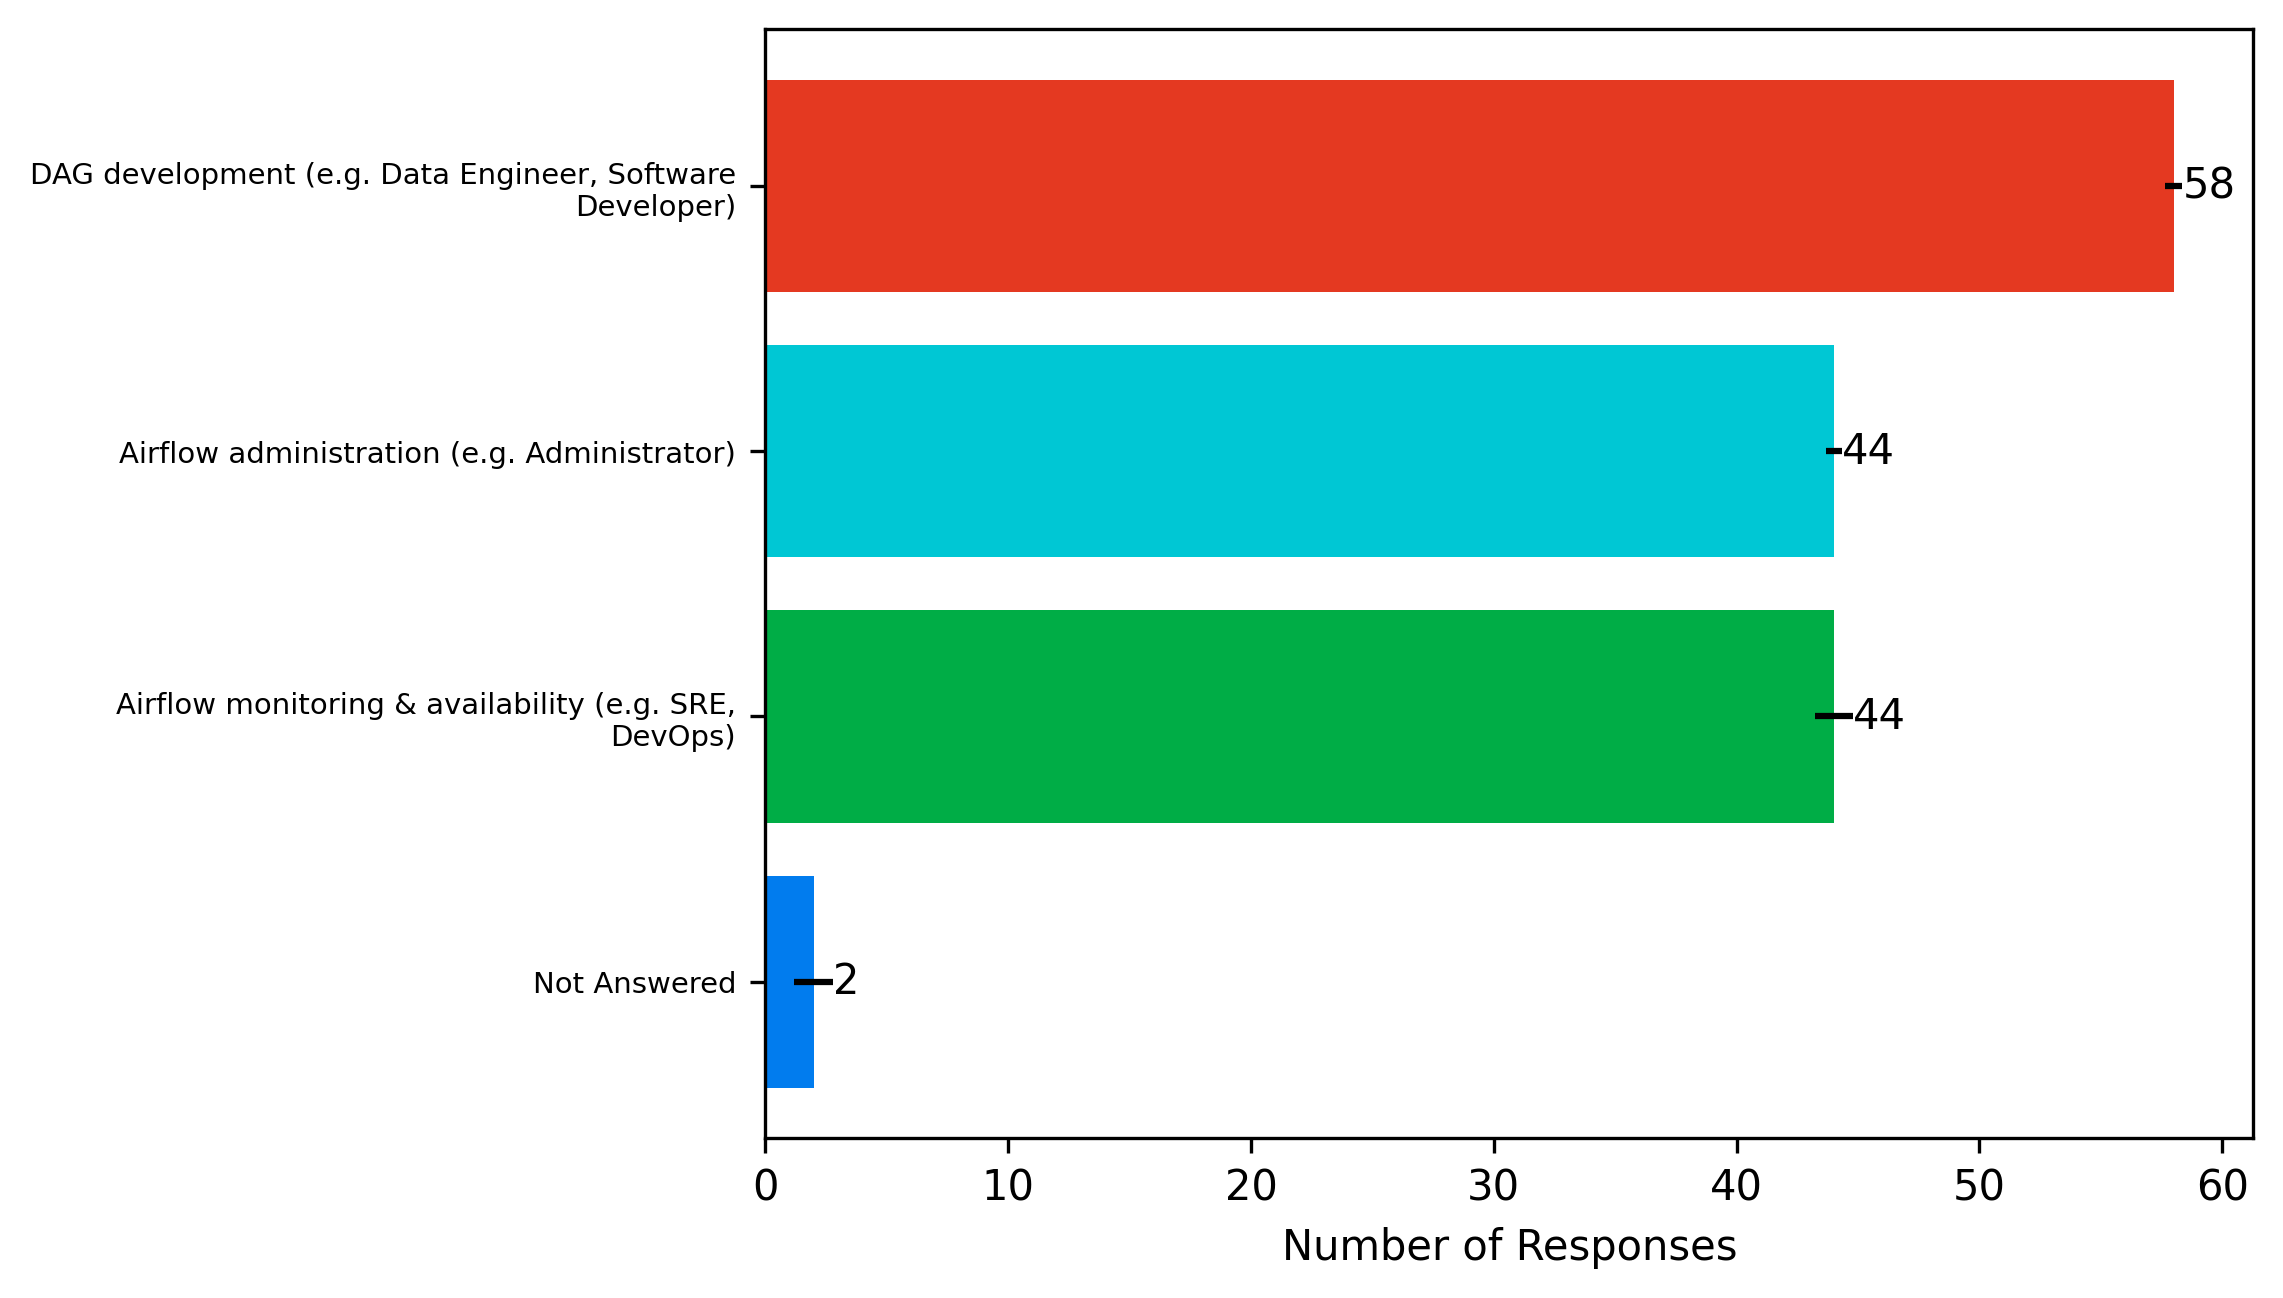

In [33]:
q52_opts = [
    "DAG development (e.g. Data Engineer, Software Developer)",
    "Airflow administration (e.g. Administrator)",
    "Airflow monitoring & availability (e.g. SRE, DevOps)",
]
q52_res = survey_df["5.2. What are your responsibilities in the context of using Airflow?"].tolist()
plot_checkbox_question_bar(q52_opts, q52_res)

# Q5.3. How would you describe your role in the context where you use Airflow most often?

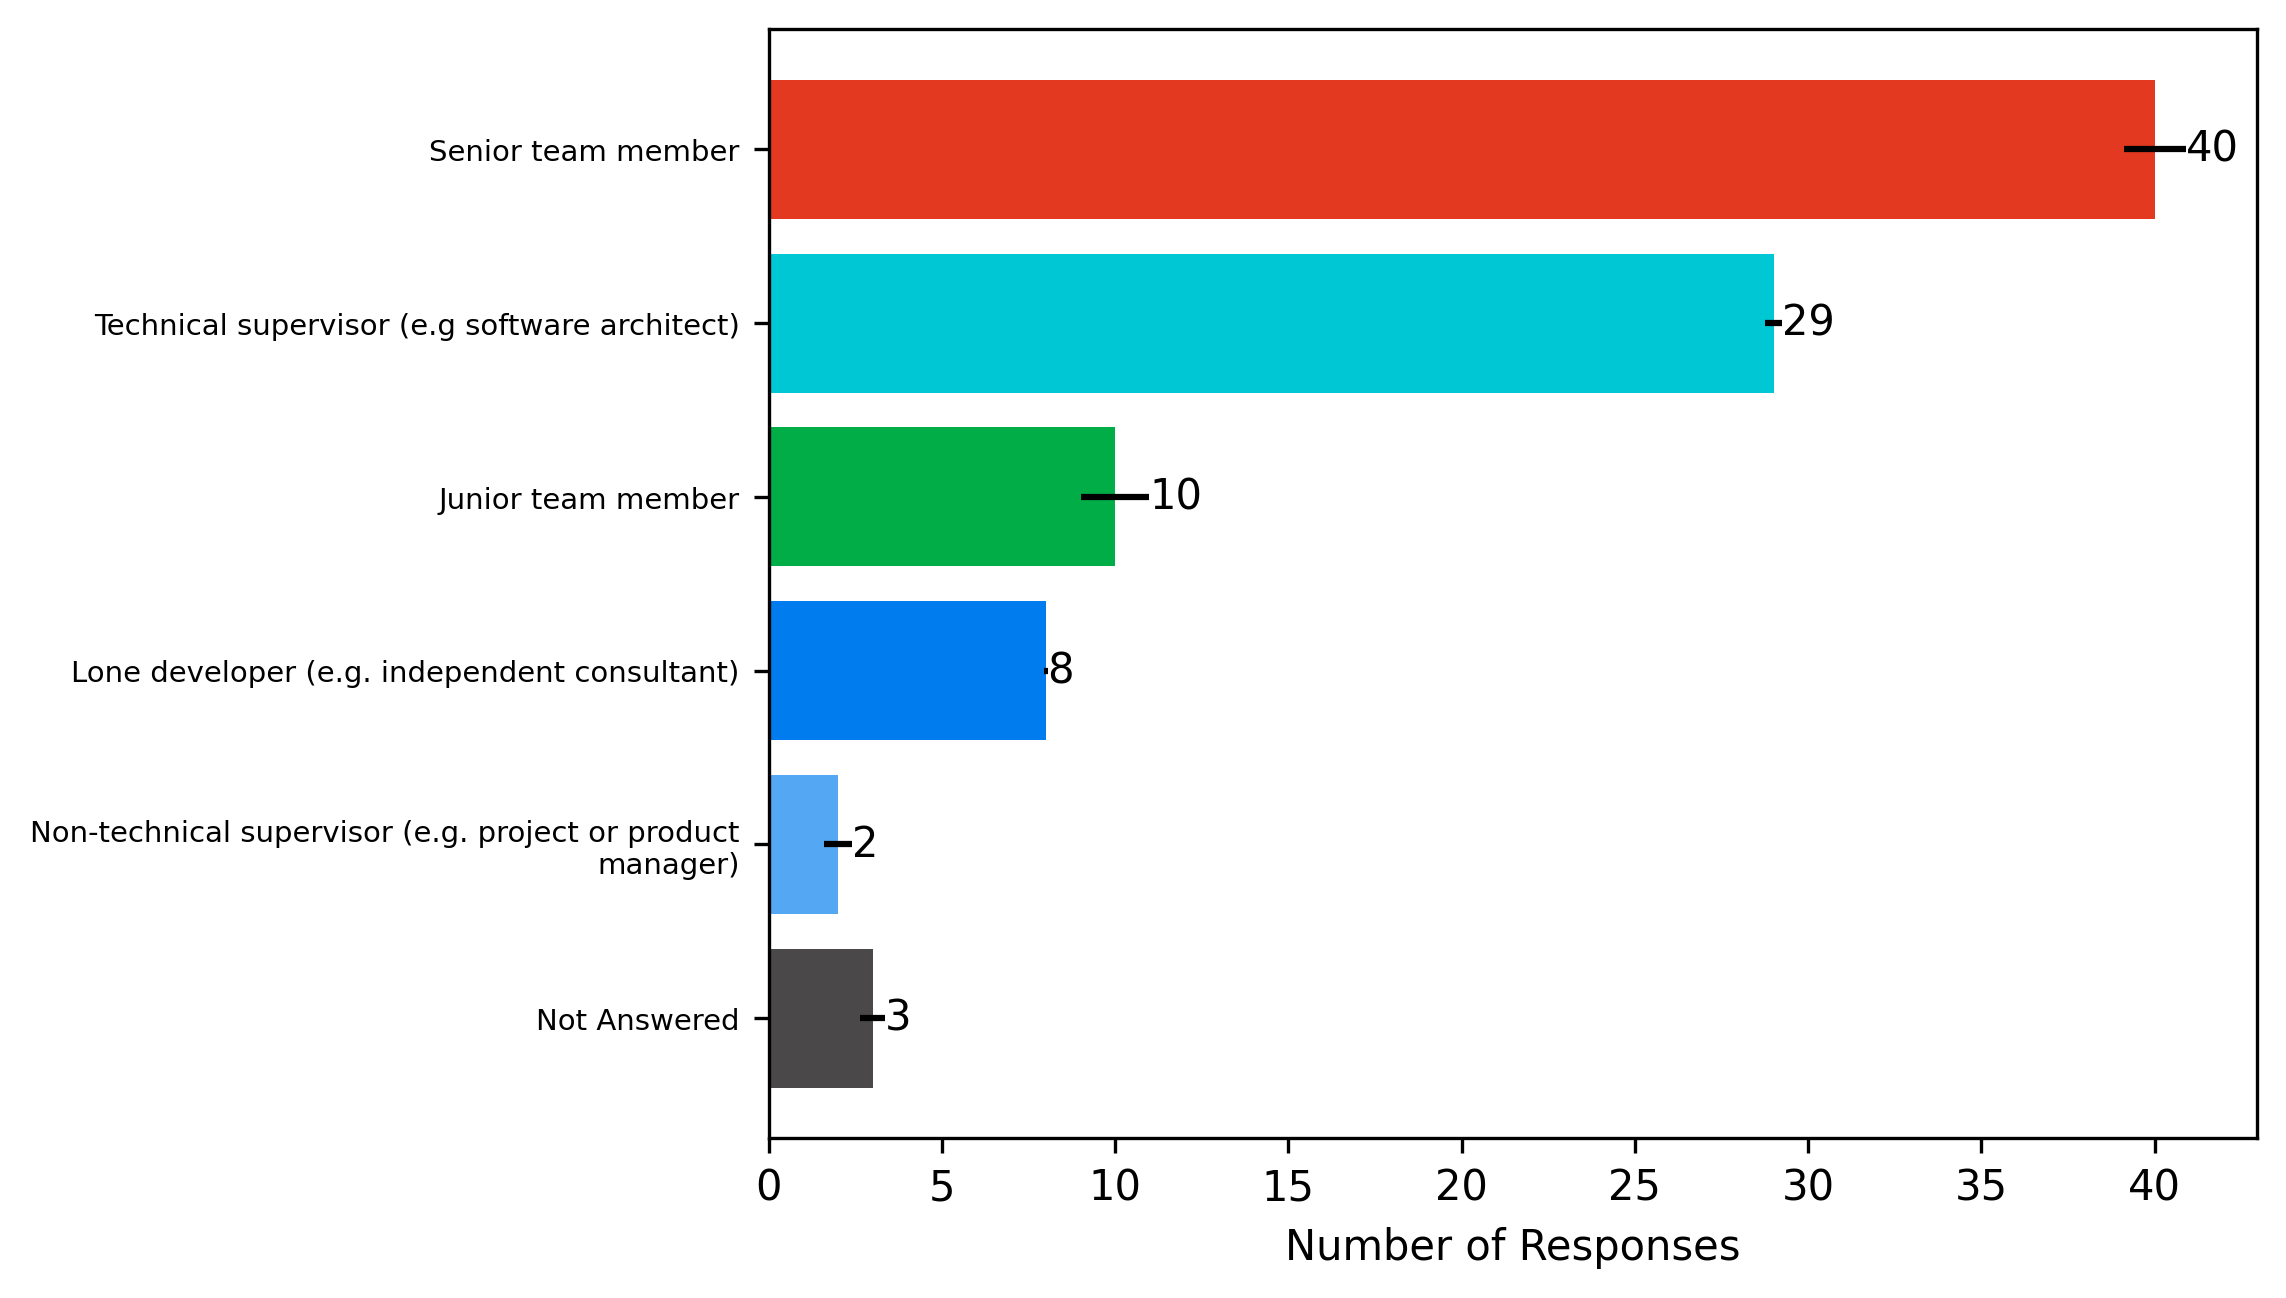

In [34]:
q53_opts = [
    "Junior team member",
    "Senior team member",
    "Technical supervisor (e.g software architect)",
    "Non-technical supervisor (e.g. project or product manager)",
    "Lone developer (e.g. independent consultant)",
]
q53_res = survey_df["5.3. How would you describe your role in the context where you use Airflow most often?"].tolist()
plot_checkbox_question_bar(q53_opts, q53_res)

# Q6.1. Free-form feedback summary

In [35]:
# markdown_print(survey_df, "6.1. Free-form feedback")
markdown_raw_print("""
Debugging Enhancements:

    Ability to save, share, and restore debugging sessions.
    Easier local execution and integration with IDE debuggers like VS Code.

DAG Management:

    Implement mechanisms for real-time DAG updates and testing.
    Improve integration with OpenTelemetry and enhance the statistics being sent.

Integration Testing Resources:

    Desire for a repository of mocks, Docker Compose setups, and sample Pytests for integration testing, ideally hosted in the Astronomer Registry.

Web UI Improvements:

    Code editor functionality in the web UI for direct editing and testing.
    Increased trigger rules.
    Ability to edit XComs from the UI.
    Options to stop, pause, and resume tasks (currently only failed, success, and clear are available).
    Dynamic scaling of mapped tasks even after they have started.
    Access to running logs for tasks.

Appreciation:

    General thanks for making Airflow a great product!
""")

### Debugging Enhancements:

- Ability to save, share, and restore debugging sessions.

- Easier local execution and integration with IDE debuggers like VS Code.

### DAG Management:

- Implement mechanisms for real-time DAG updates and testing.

- Improve integration with OpenTelemetry and enhance the statistics being sent.

### Integration Testing Resources:

- Desire for a repository of mocks, Docker Compose setups, and sample Pytests for integration testing, ideally hosted in the Astronomer Registry.

### Web UI Improvements:

- Code editor functionality in the web UI for direct editing and testing.

- Increased trigger rules.

- Ability to edit XComs from the UI.

- Options to stop, pause, and resume tasks (currently only failed, success, and clear are available).

- Dynamic scaling of mapped tasks even after they have started.

- Access to running logs for tasks.

### Appreciation:

- General thanks for making Airflow a great product!

In [36]:
# Q6.2. Feedback about the survey itself (length, thoroughness, relevance, etc.)

In [37]:
# markdown_print("6.2. Feedback about the survey itself (length, thoroughness, relevance, etc.)")